In [1]:
! pip install autogluon

     |████████████████████████████████| 273 kB 2.1 MB/s 
     |████████████████████████████████| 352 kB 36.3 MB/s 
     |████████████████████████████████| 56 kB 3.9 MB/s 
     |████████████████████████████████| 52 kB 1.3 MB/s 
     |████████████████████████████████| 206 kB 42.2 MB/s 
     |████████████████████████████████| 27.4 MB 1.6 MB/s 
     |████████████████████████████████| 802 kB 47.3 MB/s 
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
     |████████████████████████████████| 131 kB 45.3 MB/s 
     |████████████████████████████████| 4.2 MB 57.2 MB/s 
     |████████████████████████████████| 1.3 MB 43.6 MB/s 
     |████████████████████████████████| 119 kB 35.4 MB/s 
     |████████████████████████████████| 3.0 MB 42.9 MB/s 
     |████████████████████████████████| 296 kB 29.1 MB/s 
     |████████████████████████████████| 189 kB 39.8 MB/s 
     |████████████████████████████████| 67.3 MB 19 kB/s 
     |████████████████████████████████| 166.7 MB 16 kB/s 
     |██████████████

In [2]:
! pip install phate

     |████████████████████████████████| 104 kB 7.6 MB/s 
     |████████████████████████████████| 416 kB 26.0 MB/s 
     |████████████████████████████████| 45 kB 2.0 MB/s 
     |████████████████████████████████| 1.8 MB 35.2 MB/s 


In [3]:
import sys
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import torch.nn as nn
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data

from tensorflow import keras

from torch.optim import Adam, SGD
from sklearn.metrics import confusion_matrix
from keras.layers import Dense, Bidirectional, Conv1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Add

import random

In [4]:
from autogluon.tabular import TabularDataset, TabularPredictor
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.layers import SimpleRNN, LSTM

In [5]:
from tensorflow import convert_to_tensor
import tensorflow as tf

In [6]:
# genomics-specific visualization tools
import phate
import scprep

from sklearn.manifold import TSNE

import seaborn as sns

In [7]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [8]:
from pathlib import Path

DATA = Path("/gdrive/My Drive/columbia_masters/classes/2021_f/genomics/genomics_project")

In [9]:
import sys
sys.path.append(DATA)

In [10]:
%cd /gdrive/My Drive/columbia_masters/classes/2021_f/genomics/genomics_project

/gdrive/My Drive/columbia_masters/classes/2021_f/genomics/genomics_project


In [11]:
# .py file created with helper functions
from utils import *

## Load Data and Clean it

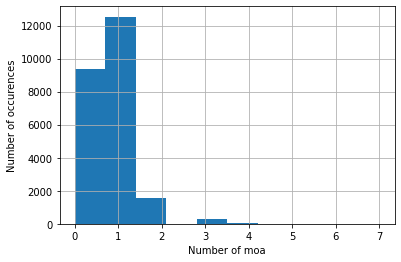

StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.3,
            train_size=None)
StratifiedShuffleSplit(n_splits=1, random_state=42, test_size=0.7,
            train_size=None)


In [12]:
# load data
df_feature, df_labels, df_raw = read_data(DATA)

# get number of moa per row, and plot histogram
n_moa = get_n_moa(df_labels)
get_plot_n_moa(df_labels)

# remove ids that have more than 1 moa or less than 1 moa
n_moa_feature, n_moa_labels = get_n_moa_per_row(df_feature, df_labels, n_moa_per_row=1)
# remove labels that occur less than min_label_occur param
sel_labels, sel_raw = sel_labels_by_occur(n_moa_labels, df_raw, min_label_occur=100)
# split data into test train and val
df_feat, df_lab = get_test_train_val(n_moa_feature, sel_labels)
# get split labels, make them categories (int) instead of hot encoded
train_labels, test_labels, val_labels = split_labels_train_test_val(df_lab)
# get split features in pandas DataFrame
train_features, test_features, val_features = split_features_train_test_val(df_feat, in_numpy=False)
# get split features in numpy ndarray
nptrain_features, nptest_features, npval_features = split_features_train_test_val(df_feat, in_numpy=True)

In [13]:
n_moa_feature.head()

,id,with_drug,time,dosage,drug,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,dtype
0,id_000644bb2,True,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,test
1,id_001626bd3,True,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,test
2,id_001762a82,True,24,D1,e06749542,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,0.0543,-0.2225,-0.1586,0.4289,0.0361,0.3543,0.8310,-0.9129,0.7677,-0.2512,0.7087,0.0481,-0.4486,1.2570,1.2550,0.3359,-0.5103,-0.2993,-1.1950,-0.3208,-0.1187,1.0030,0.9133,0.0376,0.3015,-0.9578,0.5354,1.1360,1.1310,...,2.0780,1.3350,0.9889,0.5017,2.0020,0.8918,0.4290,0.0716,0.8465,0.6596,1.3710,1.0580,1.7570,1.0030,0.2152,1.6920,-0.2930,1.4590,1.0950,0.5854,1.7270,0.5580,1.3090,1.0100,0.6980,0.5455,1.0170,1.2910,1.5430,1.8390,1.1570,-1.0120,1.9010,1.4270,0.4519,1.2120,0.3765,0.7848,1.3990,test
3,id_0020d0484,True,48,D1,8b87a7a83,0.2711,0.5133,-0.1327,2.5950,0.6980,0.5846,-0.2633,-2.1490,0.4881,1.4750,-0.0488,-0.0561,0.1641,0.1749,-0.3464,-0.1811,0.5685,1.2970,1.0510,-0.9585,0.7911,-0.2991,2.7420,-0.5979,-1.0240,0.7268,0.1590,-1.9730,1.1340,-2.5720,0.2068,0.9992,-0.1958,0.2262,1.0140,...,-0.5500,-0.0530,0.2077,-0.0825,0.2156,0.8142,1.0990,1.0860,0.4011,-0.1342,0.4653,-0.1104,0.3935,1.2370,-0.5072,0.0351,0.5084,-0.1248,0.4351,0.1389,0.6726,0.6070,0.3431,-0.4116,0.1194,0.3420,0.1331,0.8541,0.6282,0.3230,-0.4140,0.2532,0.0513,0.8600,1.4250,0.6633,0.4562,-0.9622,0.0260,test
4,id_0023f063e,True,48,D2,de7583071,-0.0630,0.2564,-0.5279,-0.2541,-0.0182,-1.5370,-0.2180,-0.0430,-0.0116,0.6565,-0.1618,-0.6742,0.7260,-0.8124,0.3477,0.2425,1.2030,-0.4435,0.8795,-0.2243,-0.1423,0.3758,-0.6869,0.2382,-0.8178,-0.7586,1.2330,1.0770,0.3447,-0.3917,0.3276,2.2610,-0.1933,0.2296,-0.1599,...,-0.0834,-0.8118,-0.4018,-1.2540,-0.9295,-0.5881,-0.8408,-0.1703,-0.0097,0.1205,-0.5683,-0.5235,-0.8461,-0.8039,-1.1390,-0.3498,-0.2183,-0.3053,-0.6116,-0.1504,-0.5320,-1.1000,-0.2852,-0.5361,-0.3377,-0.2916,-1.4360,0.3119,-1.0490,0.2201,0.5601,-0.3501,-1.4070,-0.1717,-1.1160,-0.8745,-0.2716,0.0189,-2.0000,test


In [14]:
print(f'Selected data shapes (features, labels): {(df_feat.shape, df_lab.shape)}')

Selected data shapes (features, labels): ((12532, 878), (12532, 31))


In [15]:
# get gene expression only
gene_exp_feat = get_gene_exp_features(df_feat, in_numpy=False)
npgene_exp_feat = get_gene_exp_features(df_feat, in_numpy=True)

In [16]:
# see if it worked properly
gene_exp_feat.head()

,id,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,...,g-732,g-733,g-734,g-735,g-736,g-737,g-738,g-739,g-740,g-741,g-742,g-743,g-744,g-745,g-746,g-747,g-748,g-749,g-750,g-751,g-752,g-753,g-754,g-755,g-756,g-757,g-758,g-759,g-760,g-761,g-762,g-763,g-764,g-765,g-766,g-767,g-768,g-769,g-770,g-771
0,id_000644bb2,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,0.2965,-0.5055,-0.5119,...,-0.9041,-0.8089,0.6598,-0.4772,0.1289,-0.0297,0.4564,-0.1447,0.4683,-0.1722,0.9998,1.2860,-0.6166,0.0963,1.6340,-0.8744,0.4931,-0.0283,-0.3110,-0.1117,-0.4528,1.3240,-0.0503,-1.2750,-0.1750,-0.6972,-0.2720,0.2931,1.5280,0.3453,-0.5055,-0.3167,1.0930,0.0084,0.8611,-0.5582,0.3008,1.6490,0.2968,-0.0224
1,id_001626bd3,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,-1.4470,1.0620,0.7888,...,-0.2094,1.1270,0.1874,-0.0465,1.0560,-0.6324,-0.3651,0.9485,-0.6745,0.0479,-1.0470,-1.2440,-0.7675,0.2327,0.3698,1.4900,0.3632,1.4380,-0.5047,-0.2092,-0.4386,-1.1780,0.8236,1.0540,0.6745,-0.6354,-0.6745,-1.3780,0.7521,-0.9456,-0.6904,2.0540,-0.3131,-0.0809,0.3910,1.7660,-1.0020,-0.7534,0.5000,-0.6269
2,id_001762a82,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,0.0543,-0.2225,-0.1586,0.4289,0.0361,0.3543,0.8310,-0.9129,0.7677,-0.2512,0.7087,0.0481,-0.4486,1.2570,1.2550,0.3359,-0.5103,-0.2993,-1.1950,-0.3208,-0.1187,1.0030,0.9133,0.0376,0.3015,-0.9578,0.5354,1.1360,1.1310,-0.1430,-0.0559,0.5950,-1.0050,...,0.2347,1.7340,-0.3179,-0.0674,0.0625,0.2568,0.3574,-1.5220,0.6799,-0.1855,-0.3658,0.7496,0.5610,1.1440,-0.5849,1.1840,0.5497,0.0238,0.1425,-0.0735,-1.9930,-0.0062,-0.1116,-1.7200,0.0000,-0.0169,0.7212,-0.7499,-0.0713,-0.7886,0.1126,0.4842,-0.4471,0.1982,0.1351,0.1498,-0.4674,0.9579,0.1993,0.0592
3,id_0020d0484,0.2711,0.5133,-0.1327,2.5950,0.6980,0.5846,-0.2633,-2.1490,0.4881,1.4750,-0.0488,-0.0561,0.1641,0.1749,-0.3464,-0.1811,0.5685,1.2970,1.0510,-0.9585,0.7911,-0.2991,2.7420,-0.5979,-1.0240,0.7268,0.1590,-1.9730,1.1340,-2.5720,0.2068,0.9992,-0.1958,0.2262,1.0140,1.3170,-2.4110,-6.3870,0.6364,...,-0.4459,-1.4550,0.4910,-1.8030,0.5707,-0.5121,-0.7822,0.0237,-0.3289,0.0651,-0.8492,-1.1390,2.4410,3.1790,0.5241,0.6403,0.3883,-0.5364,2.5070,0.0365,1.4730,0.9430,0.4221,-0.4104,0.0000,2.5800,-1.5910,-0.1997,-0.2239,-4.5060,0.3843,3.0690,-0.7682,1.3920,-1.9820,-1.8910,1.1250,0.6872,0.0641,1.3280
4,id_0023f063e,-0.0630,0.2564,-0.5279,-0.2541,-0.0182,-1.5370,-0.2180,-0.0430,-0.0116,0.6565,-0.1618,-0.6742,0.7260,-0.8124,0.3477,0.2425,1.2030,-0.4435,0.8795,-0.2243,-0.1423,0.3758,-0.6869,0.2382,-0.8178,-0.7586,1.2330,1.0770,0.3447,-0.3917,0.3276,2.2610,-0.1933,0.2296,-0.1599,0.0780,0.5552,-0.9599,-0.3522,...,0.8607,0.0162,0.6687,0.4723,-1.3410,0.3620,-0.4446,-0.2199,-0.6276,0.5777,-0.6095,0.1234,0.2875,1.2330,0.8081,0.2056,-0.5950,-0.0282,-0.0811,0.6988,0.3676,-0.5809,-0.7153,-0.7473,-0.4396,-0.4507,0.8305,-0.2183,-0.5124,-0.1496,-0.4106,1.3090,0.7485,0.5926,-0.6437,-0.0956,-0.4281,0.6985,-0.8000,0.7218


In [17]:
get_c_g_features(df_feat, in_numpy=False).head()

,id,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,g-37,g-38,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,0.2965,-0.5055,-0.5119,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_001626bd3,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,-1.4470,1.0620,0.7888,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
2,id_001762a82,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,0.0543,-0.2225,-0.1586,0.4289,0.0361,0.3543,0.8310,-0.9129,0.7677,-0.2512,0.7087,0.0481,-0.4486,1.2570,1.2550,0.3359,-0.5103,-0.2993,-1.1950,-0.3208,-0.1187,1.0030,0.9133,0.0376,0.3015,-0.9578,0.5354,1.1360,1.1310,-0.1430,-0.0559,0.5950,-1.0050,...,0.6701,2.0780,1.3350,0.9889,0.5017,2.0020,0.8918,0.4290,0.0716,0.8465,0.6596,1.3710,1.0580,1.7570,1.0030,0.2152,1.6920,-0.2930,1.4590,1.0950,0.5854,1.7270,0.5580,1.3090,1.0100,0.6980,0.5455,1.0170,1.2910,1.5430,1.8390,1.1570,-1.0120,1.9010,1.4270,0.4519,1.2120,0.3765,0.7848,1.3990
3,id_0020d0484,0.2711,0.5133,-0.1327,2.5950,0.6980,0.5846,-0.2633,-2.1490,0.4881,1.4750,-0.0488,-0.0561,0.1641,0.1749,-0.3464,-0.1811,0.5685,1.2970,1.0510,-0.9585,0.7911,-0.2991,2.7420,-0.5979,-1.0240,0.7268,0.1590,-1.9730,1.1340,-2.5720,0.2068,0.9992,-0.1958,0.2262,1.0140,1.3170,-2.4110,-6.3870,0.6364,...,-0.2623,-0.5500,-0.0530,0.2077,-0.0825,0.2156,0.8142,1.0990,1.0860,0.4011,-0.1342,0.4653,-0.1104,0.3935,1.2370,-0.5072,0.0351,0.5084,-0.1248,0.4351,0.1389,0.6726,0.6070,0.3431,-0.4116,0.1194,0.3420,0.1331,0.8541,0.6282,0.3230,-0.4140,0.2532,0.0513,0.8600,1.4250,0.6633,0.4562,-0.9622,0.0260
4,id_0023f063e,-0.0630,0.2564,-0.5279,-0.2541,-0.0182,-1.5370,-0.2180,-0.0430,-0.0116,0.6565,-0.1618,-0.6742,0.7260,-0.8124,0.3477,0.2425,1.2030,-0.4435,0.8795,-0.2243,-0.1423,0.3758,-0.6869,0.2382,-0.8178,-0.7586,1.2330,1.0770,0.3447,-0.3917,0.3276,2.2610,-0.1933,0.2296,-0.1599,0.0780,0.5552,-0.9599,-0.3522,...,-0.5233,-0.0834,-0.8118,-0.4018,-1.2540,-0.9295,-0.5881,-0.8408,-0.1703,-0.0097,0.1205,-0.5683,-0.5235,-0.8461,-0.8039,-1.1390,-0.3498,-0.2183,-0.3053,-0.6116,-0.1504,-0.5320,-1.1000,-0.2852,-0.5361,-0.3377,-0.2916,-1.4360,0.3119,-1.0490,0.2201,0.5601,-0.3501,-1.4070,-0.1717,-1.1160,-0.8745,-0.2716,0.0189,-2.0000


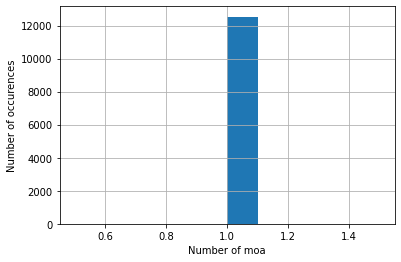

In [18]:
# n_moa post-selection
get_plot_n_moa(n_moa_labels);

In [19]:
temp = (np.argmax(df_lab.drop(columns=['id', 'dtype']).to_numpy(), axis=0))
temp
# np.argmax(train_labels, axis=1)

array([ 34,  32, 166,  37, 188, 122,   1,  76,   3,  21,   7, 172,  45,
        24,  68, 108,  14,  42,   9,  23,  41, 103,  26,  46,  11,  22,
        27,  35,  73])

In [20]:
# these are our labels
moa_label_names = pd.Series(list(df_lab.drop(columns=['id', 'dtype']).columns))
moa_label_names.values

array(['acetylcholine_receptor_agonist',
       'acetylcholine_receptor_antagonist', 'adrenergic_receptor_agonist',
       'adrenergic_receptor_antagonist',
       'bacterial_cell_wall_synthesis_inhibitor',
       'bacterial_dna_inhibitor', 'calcium_channel_blocker',
       'cc_chemokine_receptor_antagonist', 'cdk_inhibitor',
       'cyclooxygenase_inhibitor', 'dna_inhibitor',
       'dopamine_receptor_agonist', 'dopamine_receptor_antagonist',
       'egfr_inhibitor', 'estrogen_receptor_agonist',
       'gaba_receptor_antagonist', 'glucocorticoid_receptor_agonist',
       'glutamate_receptor_antagonist', 'hdac_inhibitor',
       'histamine_receptor_antagonist', 'hmgcr_inhibitor',
       'phosphodiesterase_inhibitor', 'pi3k_inhibitor', 'raf_inhibitor',
       'serotonin_receptor_agonist', 'serotonin_receptor_antagonist',
       'sodium_channel_inhibitor', 'topoisomerase_inhibitor',
       'tubulin_inhibitor'], dtype=object)

In [21]:
# check how many labels we have, and their counts
np.unique(train_labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 array([2959,  149,  124,  165,   87,   59,  127,   47,  169,  184,  159,
          47,  152,  147,   62,   70,  108,  164,   53,  121,  134,  109,
          47,  103,  115,  148,  128,   48,  141]))

In [22]:
# showing that the split worked
df_lab['dtype'].value_counts()

train    6126
test     5278
val      1128
Name: dtype, dtype: int64

In [23]:
# dimensions of test/train/val data
print(f'Train, test, val labels {(train_labels.shape, test_labels.shape, val_labels.shape)}')
print(f'Train, test, val features {(train_features.shape, test_features.shape, val_features.shape)}')

Train, test, val labels ((6126,), (5278,), (1128,))
Train, test, val features ((6126, 876), (5278, 876), (1128, 876))


In [24]:
# get ordinal labels
ordinal_labels = get_labels_ordinal(df_lab)
ordinal_labels_full = get_labels_ordinal(df_labels)

Text(0, 0.5, '# Labels')

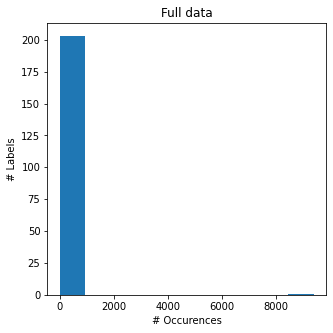

In [25]:
fig, ax1 = plt.subplots(figsize=(5, 5), sharex=True)
ax1.hist(np.unique(ordinal_labels_full, return_counts=True)[1], bins=10)
ax1.set_title('Full data')
ax1.set_xlabel('# Occurences')
ax1.set_ylabel('# Labels')

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

Text(0, 0.5, '# Occurences')

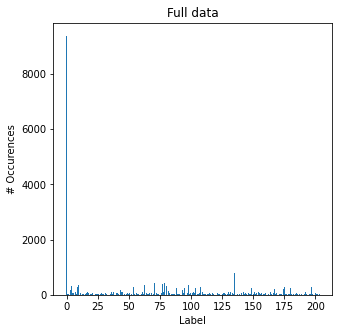

In [35]:
fig, ax1 = plt.subplots(figsize=(5, 5), sharex=True)
ax1.bar(x=np.linspace(0, len(np.unique(ordinal_labels_full, return_counts=True)[1])-1, len(np.unique(ordinal_labels_full, return_counts=True)[1])), 
        height=np.unique(ordinal_labels_full, return_counts=True)[1])
ax1.set_title('Full data')
ax1.set_xlabel('Label')
ax1.set_ylabel('# Occurences')

Text(0, 0.5, '# Labels')

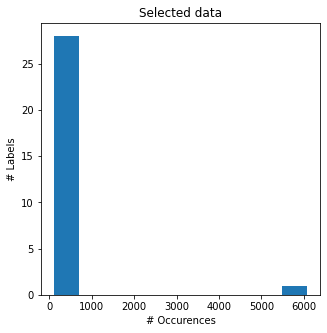

In [26]:
ig, ax2 = plt.subplots(figsize=(5, 5), sharex=True)
ax2.set_title('Selected data')
ax2.hist(np.unique(ordinal_labels, return_counts=True)[1], bins=10)
ax2.set_xlabel('# Occurences')
ax2.set_ylabel('# Labels')

## Data Visualization

In [36]:
# remove all columns except those starting with a g or with a c
npbio_feat = get_c_g_features(df_feat, in_numpy=True)

In [37]:
# remove all columns except those starting with a g 
npgene_exp_feat = get_gene_exp_features(df_feat, in_numpy=True)
# get moas of ordinal labels
name_labels = list(moa_label_names[ordinal_labels.astype(int)].values)

In [38]:
(npbio_feat.shape, npgene_exp_feat.shape)

((12532, 872), (12532, 772))

PHATE on gene expression only

In [ ]:
# https://www.nature.com/articles/s41587-019-0336-3
phate_op = phate.PHATE()
genex_phate = phate_op.fit_transform(npgene_exp_feat)

Calculating PHATE...
  Running PHATE on 12532 observations and 772 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.93 seconds.
    Calculating KNN search...
    Calculated KNN search in 22.49 seconds.
    Calculating affinities...
    Calculated affinities in 3.04 seconds.
  Calculated graph and diffusion operator in 27.50 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.58 seconds.
    Calculating KMeans...
    Calculated KMeans in 34.95 seconds.
  Calculated landmark operator in 38.99 seconds.
  Calculating optimal t...
    Automatically selected t = 40
  Calculated optimal t in 4.27 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 2.55 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 7.26 seconds.
Calculated PHATE in 80.62 seconds.


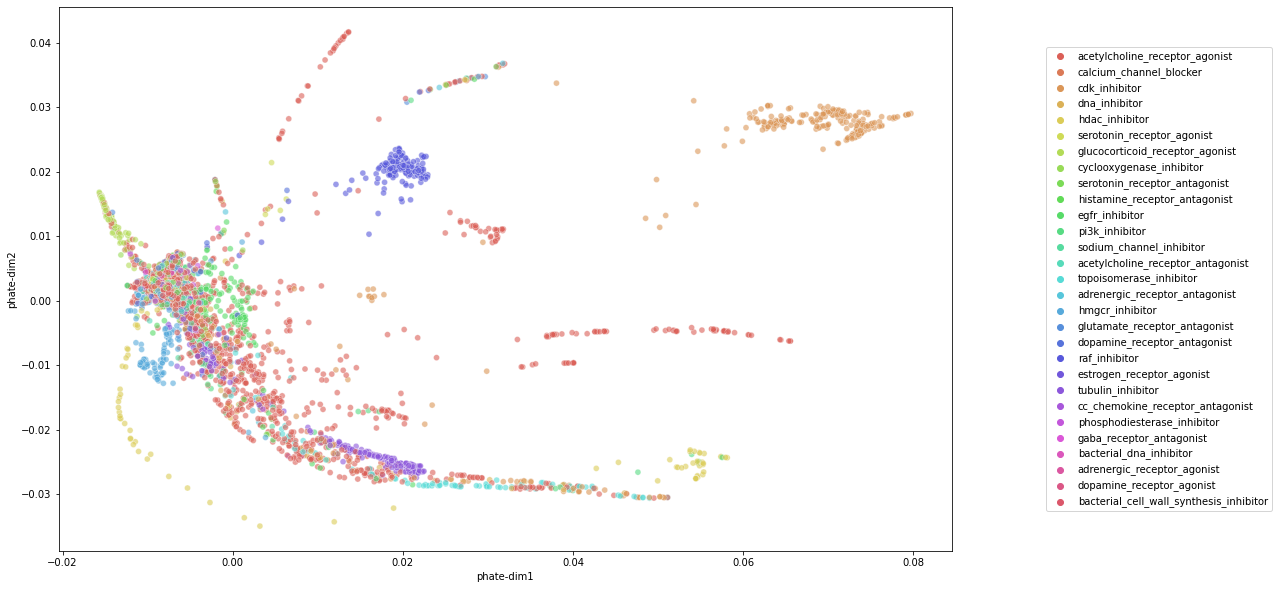

In [ ]:
phate_df = pd.DataFrame()
phate_df['MOAs'] = name_labels
phate_df['phate-dim1'] = genex_phate[:,0]
phate_df['phate-dim2'] = genex_phate[:,1]

plt.figure(figsize=(16,10))
plot_phate1 = sns.scatterplot(
    x="phate-dim1", y="phate-dim2",
    hue="MOAs",
    palette=sns.color_palette("hls", np.unique(train_labels)[-1]+1),
    data=phate_df,
    legend="full",
    alpha=0.6
)
plot_phate1.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)

<Figure size 1152x720 with 0 Axes>

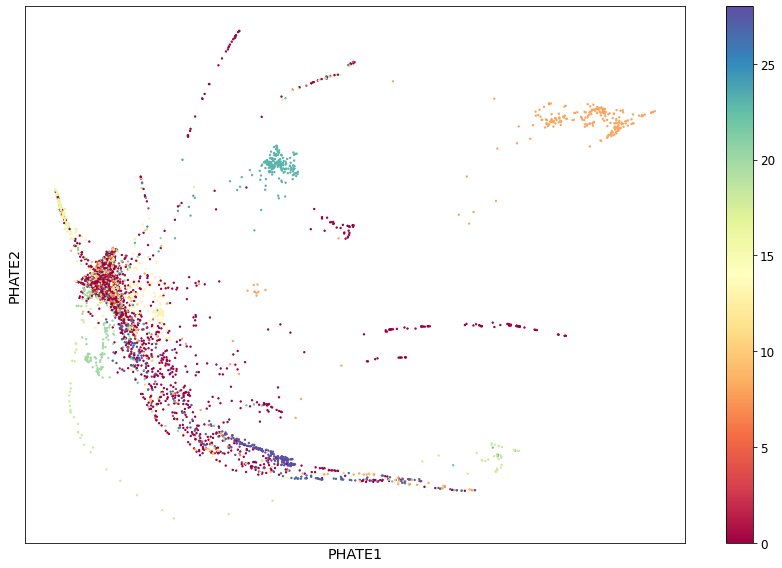

In [ ]:
plt.figure(figsize=(16,10))
plot_phate2 = scprep.plot.scatter2d(genex_phate, c=ordinal_labels, figsize=(12,8), cmap="Spectral",
                      ticks=False, label_prefix="PHATE")

PHATE on all c or g data

In [39]:
phate_op = phate.PHATE()
bio_phate = phate_op.fit_transform(npbio_feat)


Calculating PHATE...
  Running PHATE on 12532 observations and 872 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 2.35 seconds.
    Calculating KNN search...
    Calculated KNN search in 52.20 seconds.
    Calculating affinities...
    Calculated affinities in 11.29 seconds.
  Calculated graph and diffusion operator in 65.98 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 4.93 seconds.
    Calculating KMeans...
    Calculated KMeans in 51.66 seconds.
  Calculated landmark operator in 59.41 seconds.
  Calculating optimal t...
    Automatically selected t = 31
  Calculated optimal t in 9.05 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 6.66 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 10.12 seconds.
Calculated PHATE in 151.28 seconds.


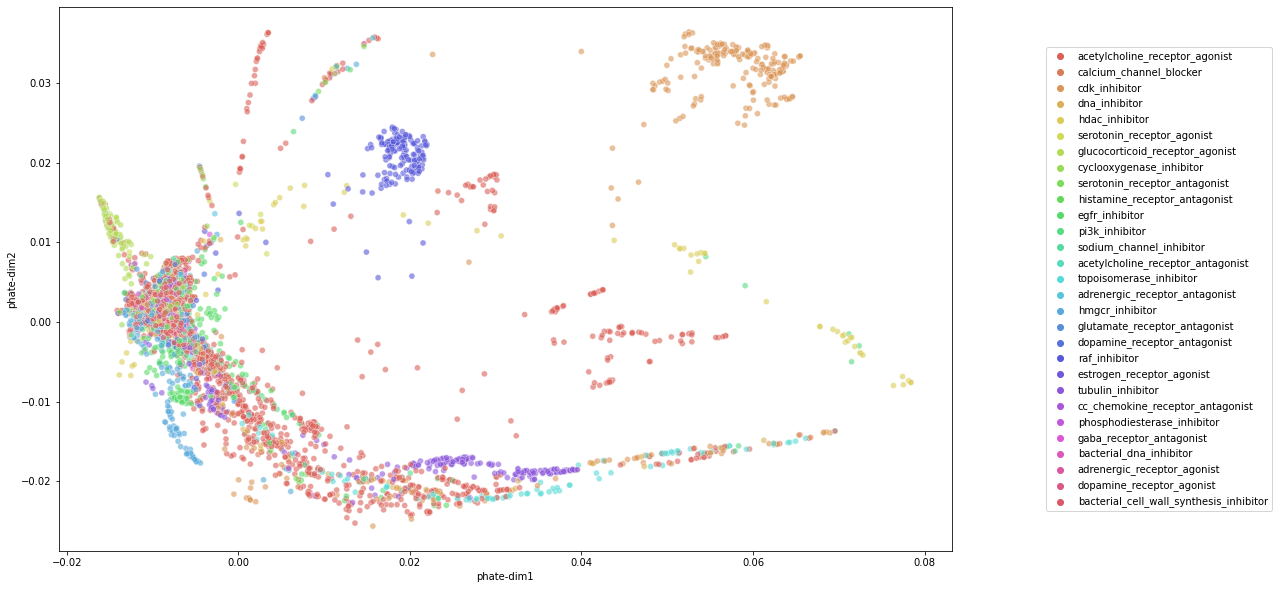

In [ ]:
phate_df = pd.DataFrame()
phate_df['MOAs'] = name_labels
phate_df['phate-dim1'] = bio_phate[:,0]
phate_df['phate-dim2'] = bio_phate[:,1]

plt.figure(figsize=(16,10))
plot_phate3 = sns.scatterplot(
    x="phate-dim1", y="phate-dim2",
    hue="MOAs",
    palette=sns.color_palette("hls", np.unique(train_labels)[-1]+1),
    data=phate_df,
    legend="full",
    alpha=0.6
)
plot_phate3.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)

t_SNE on gene expression data

In [ ]:
# t-SNE
tsne = TSNE(verbose = 2)
genex_tsne = tsne.fit_transform(npgene_exp_feat)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12532 samples in 0.009s...
[t-SNE] Computed neighbors for 12532 samples in 11.291s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12532
[t-SNE] Computed conditional probabilities for sample 2000 / 12532
[t-SNE] Computed conditional probabilities for sample 3000 / 12532
[t-SNE] Computed conditional probabilities for sample 4000 / 12532
[t-SNE] Computed conditional probabilities for sample 5000 / 12532
[t-SNE] Computed conditional probabilities for sample 6000 / 12532
[t-SNE] Computed conditional probabilities for sample 7000 / 12532
[t-SNE] Computed conditional probabilities for sample 8000 / 12532
[t-SNE] Computed conditional probabilities for sample 9000 / 12532
[t-SNE] Computed conditional probabilities for sample 10000 / 12532
[t-SNE] Computed conditional probabilities for sample 11000 / 12532
[t-SNE] Computed conditional probabilities for sample 12000 / 12532
[t-SNE] Computed conditional probabilities for sa

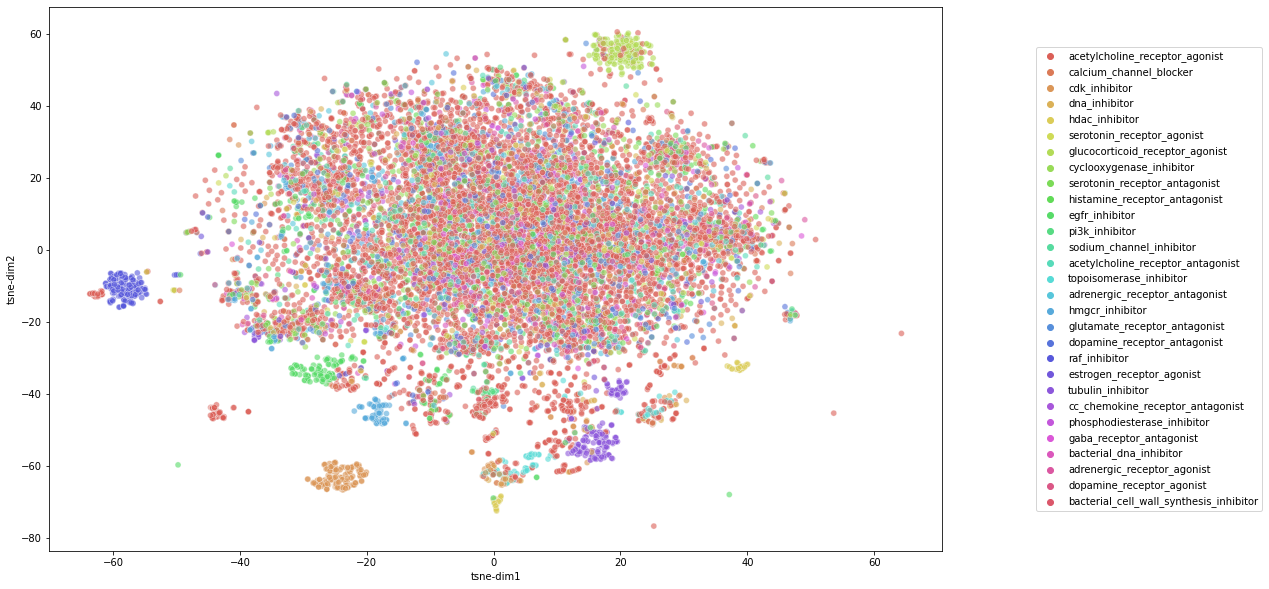

In [ ]:
# Plot lower-dimensional representations of samples, colored by family_accession
tsne_df = pd.DataFrame()
tsne_df['y'] = name_labels
tsne_df['tsne-dim1'] = genex_tsne[:,0]
tsne_df['tsne-dim2'] = genex_tsne[:,1]
plt.figure(figsize=(16,10))
plot_tsne1 = sns.scatterplot(
    x="tsne-dim1", y="tsne-dim2",
    hue="y",
    palette=sns.color_palette("hls", np.unique(train_labels)[-1]+1),
    data=tsne_df,
    legend="full",
    alpha=0.6
)
plot_tsne1.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)

t-SNE on all c or g data

In [40]:
# t-SNE
tsne = TSNE(verbose = 2)
bio_tsne = tsne.fit_transform(npbio_feat)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12532 samples in 0.009s...
[t-SNE] Computed neighbors for 12532 samples in 19.112s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12532
[t-SNE] Computed conditional probabilities for sample 2000 / 12532
[t-SNE] Computed conditional probabilities for sample 3000 / 12532
[t-SNE] Computed conditional probabilities for sample 4000 / 12532
[t-SNE] Computed conditional probabilities for sample 5000 / 12532
[t-SNE] Computed conditional probabilities for sample 6000 / 12532
[t-SNE] Computed conditional probabilities for sample 7000 / 12532
[t-SNE] Computed conditional probabilities for sample 8000 / 12532
[t-SNE] Computed conditional probabilities for sample 9000 / 12532
[t-SNE] Computed conditional probabilities for sample 10000 / 12532
[t-SNE] Computed conditional probabilities for sample 11000 / 12532
[t-SNE] Computed conditional probabilities for sample 12000 / 12532
[t-SNE] Computed conditional probabilities for sa

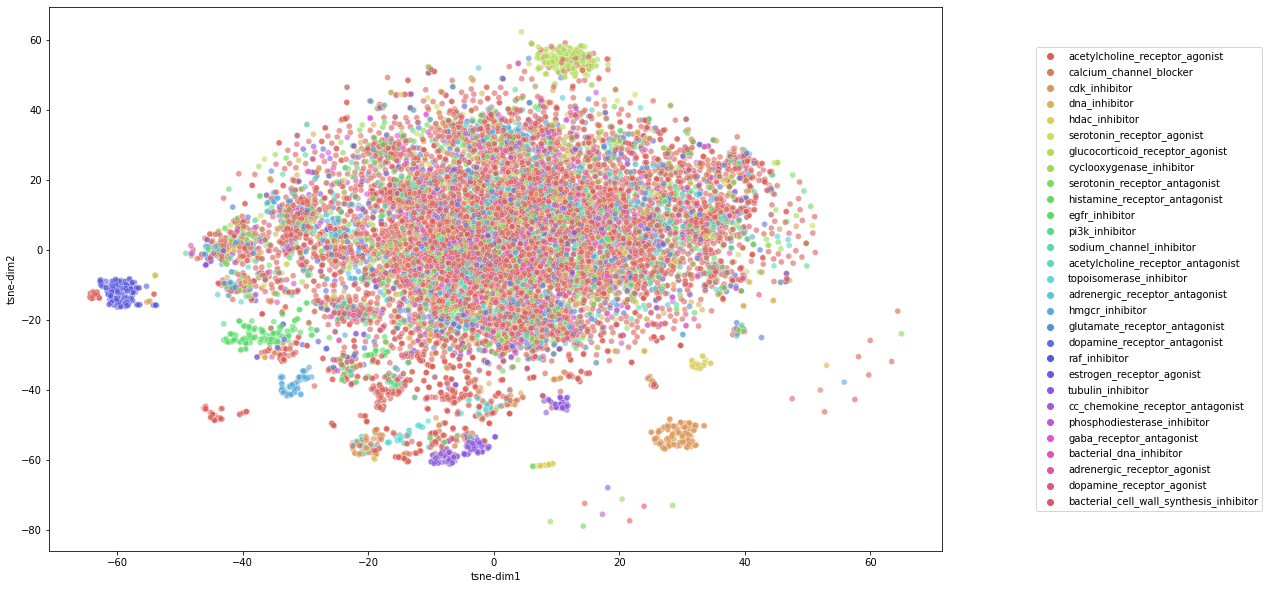

In [ ]:
# Plot lower-dimensional representations of samples, colored by family_accession
tsne_df = pd.DataFrame()
tsne_df['y'] = name_labels
tsne_df['tsne-dim1'] = bio_tsne[:,0]
tsne_df['tsne-dim2'] = bio_tsne[:,1]
plt.figure(figsize=(16,10))
plot_tsne1 = sns.scatterplot(
    x="tsne-dim1", y="tsne-dim2",
    hue="y",
    palette=sns.color_palette("hls", np.unique(train_labels)[-1]+1),
    data=tsne_df,
    legend="full",
    alpha=0.6
)
plot_tsne1.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1)

Split PHATE and t-SNE data into test/train/val

(same split as regular data)

In [42]:
# create df for phate results
df_phate = pd.DataFrame(bio_phate)
df_phate['labels'] = ordinal_labels
df_phate['dtype'] = n_moa_feature.dtype

# create df for tsne results
df_tsne =  pd.DataFrame(bio_tsne)
df_tsne['labels'] = ordinal_labels
df_tsne['dtype'] = n_moa_feature.dtype

# get split tsne data (including labels) in pandas DataFrame
new_test_tsne, train_tsne, val_tsne = split_data_train_test_val(df_tsne, in_numpy=False)

# get split tsne data (including labels) in pandas DataFrame
new_test_phate, train_phate, val_phate = split_data_train_test_val(df_phate, in_numpy=False)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [43]:
# for autogluon, we don't need to separate test and val
# so, join val to train, creating a bigger training set
new_train_tsne = pd.concat([train_tsne, val_tsne])
new_train_phate = pd.concat([train_phate, val_phate])

In [48]:
# dimensions of test/train data
print(f'Train, test t-SNE {(new_train_tsne.shape, new_test_tsne.shape)}')
print(f'Train, test PHATE {(new_train_phate.shape, new_test_phate.shape)}')

Train, test t-SNE ((6406, 3), (6126, 3))
Train, test PHATE ((6406, 3), (6126, 3))


In [45]:
new_test_tsne.head()

,0,1,labels
0,-29.724087,-7.442990,17
1,-10.615421,-0.722476,0
2,-31.044170,14.434394,11
3,3.115471,44.470879,0
4,31.452831,-54.050957,18


In [46]:
new_test_phate.head()

,0,1,labels
0,-0.010292,0.001682,17
1,-0.009073,-0.000201,0
2,-0.011245,0.001968,11
3,-0.011785,0.000468,0
4,0.050372,0.005248,18


Split c-g data into test/train/val

(same split as regular data)

In [50]:
# c_g data
df_c_g = pd.DataFrame(npbio_feat)
df_c_g['labels'] = ordinal_labels
df_c_g['dtype'] = n_moa_feature.dtype

# get split tsne data (including labels) in pandas DataFrame
new_test_c_g, train_c_g, val_c_g = split_data_train_test_val(df_c_g, in_numpy=False)

# for autogluon, we don't need to separate test and val
# so, join val to train to have more training data
new_train_c_g = pd.concat([train_c_g, val_c_g])

print(f'Train, test c-g data {(new_train_c_g.shape, new_test_c_g.shape)}')

Train, test c-g data ((6406, 873), (6126, 873))


/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## Prediction model
### 1. Autogluon
### 2. Neural Network
* 1 to 4 convolutional neural network (CNN) layers
* 1 to 2 bidirectional recurrent neural network (RNN) layers
* 1 to 2 fully connected (FC) layers, in a global architecture layout CNN-RNN-FC

All Data

In [106]:
temp1 = train_features
temp1['labels'] = train_labels
temp2 = val_features
temp2['labels'] = val_labels
new_train_data = pd.concat([temp1, temp2])

test_data = test_features
test_data['labels'] = test_labels

In [ ]:
temp_label_counts = np.unique(new_train_data['labels'].values, return_counts=True)[1]
print(f'Range of label counts: min = {temp_label_counts[-1]}, max = {temp_label_counts[0]}')

Range of label counts: min = 167, max = 3523


Range of label counts: min = 167, max = 3523


Text(0, 0.5, '# Labels')

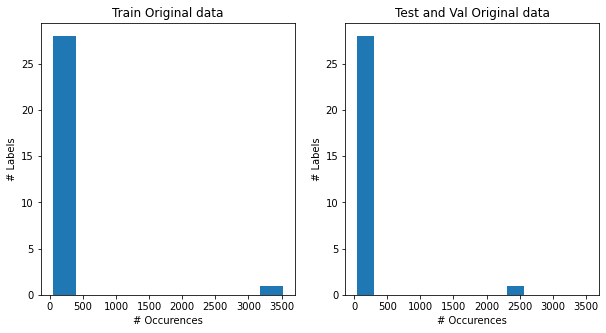

In [ ]:
temp_label_counts = np.unique(new_train_data['labels'].values, return_counts=True)[1]
print(f'Range of label counts: min = {temp_label_counts[-1]}, max = {temp_label_counts[0]}')
fig, (ax1_, ax2_) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
ax1_.hist(temp_label_counts, bins=10)
ax1_.set_title('Train Original data')
ax1_.set_xlabel('# Occurences')
ax1_.set_ylabel('# Labels')

ax2_.hist(np.unique(test_data['labels'].values, return_counts=True)[1], bins=10)
ax2_.set_title('Test and Val Original data')
ax2_.set_xlabel('# Occurences')
ax2_.set_ylabel('# Labels')

In [ ]:
save_path = 'autogluon_model'  # specifies folder to store trained models
# predictor = TabularPredictor(label='labels', path=DATA/save_path).fit(new_train_data)

In [ ]:
predictor = TabularPredictor.load(save_path)
y_pred = predictor.predict(test_data.drop(colums=['labels']))
print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true=test_data['labels'], y_pred=y_pred, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.9935581659719591
Evaluations on test data:
{
    "accuracy": 0.9935581659719591,
    "balanced_accuracy": 0.9831960247730401,
    "mcc": 0.9914524503768195
}


Predictions:  
 0        0
1        6
2        0
3        8
4        0
        ..
5273     0
5274     0
5275     0
5276    24
5277    13
Name: labels, Length: 5278, dtype: int64


In [ ]:
autogluon_accuracies = predictor.leaderboard()
autogluon_accuracies = autogluon_accuracies.rename(columns={'score_val':'accuracy_val'})
autogluon_accuracies

                  model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.997245       0.457079  2818.764307                0.002862           0.672512            2       True         13
1              CatBoost   0.990358       0.055911  2168.637975                0.055911        2168.637975            1       True          8
2       NeuralNetFastAI   0.971074       0.309232    27.714371                0.309232          27.714371            1       True          3
3              LightGBM   0.954545       0.243737   599.722890                0.243737         599.722890            1       True          5
4               XGBoost   0.951791       0.089074   621.739449                0.089074         621.739449            1       True         11
5         LightGBMLarge   0.950413       0.649085  1894.998363                0.649085        1894.998363            1       True         12
6            

,model,accuracy_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.997245,0.457079,2818.764307,0.002862,0.672512,2,True,13
1,CatBoost,0.990358,0.055911,2168.637975,0.055911,2168.637975,1,True,8
2,NeuralNetFastAI,0.971074,0.309232,27.714371,0.309232,27.714371,1,True,3
3,LightGBM,0.954545,0.243737,599.722890,0.243737,599.722890,1,True,5
4,XGBoost,0.951791,0.089074,621.739449,0.089074,621.739449,1,True,11
5,LightGBMLarge,0.950413,0.649085,1894.998363,0.649085,1894.998363,1,True,12
6,LightGBMXT,0.896694,0.603696,606.153201,0.603696,606.153201,1,True,4
7,KNeighborsUnif,0.608815,0.500135,0.522425,0.500135,0.522425,1,True,1
8,KNeighborsDist,0.606061,0.499529,0.507426,0.499529,0.507426,1,True,2
9,RandomForestGini,0.592287,0.210967,117.438373,0.210967,117.438373,1,True,6


#### Plot confusion matrix for Autogluon

In [ ]:
name_labels1 = list(moa_label_names[test_data['labels'].astype(int)].values)

In [ ]:
# get confusion matrix for predictions
cm = confusion_matrix(test_data['labels'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=name_labels1)

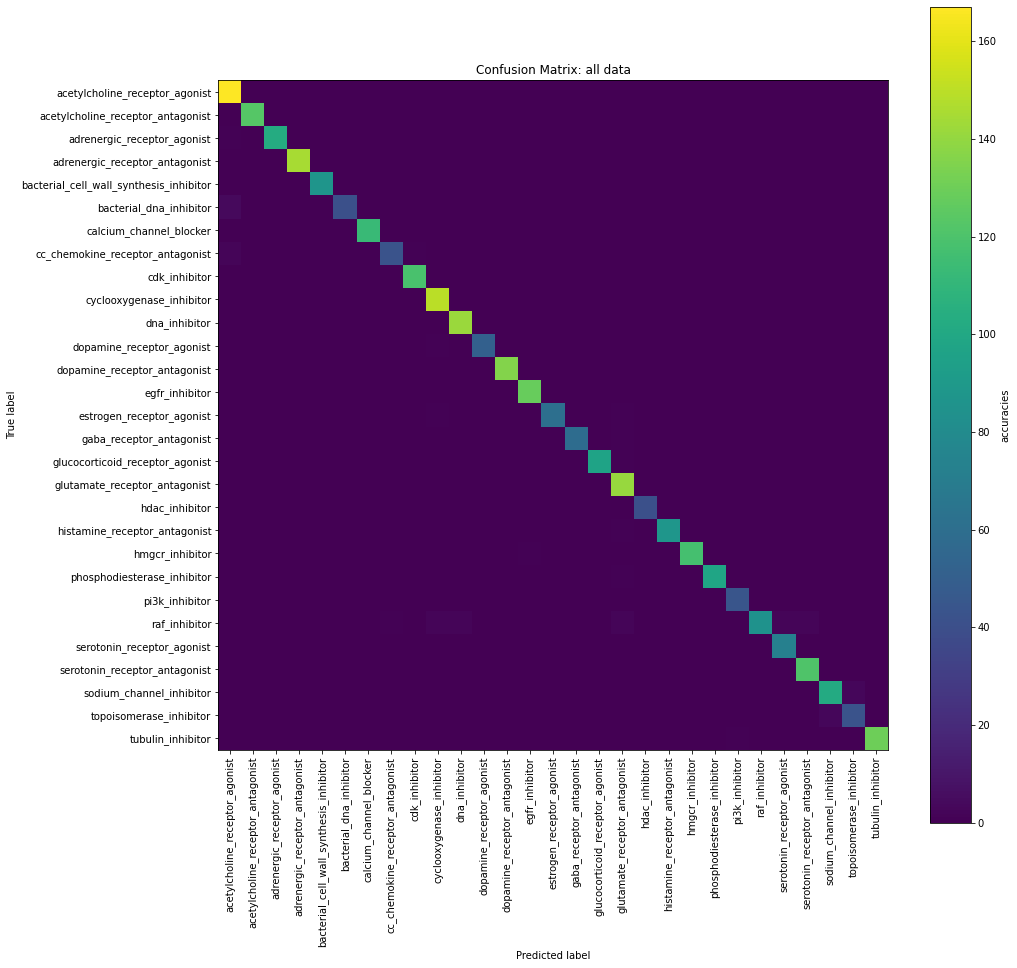

In [ ]:
accuracies = cm#/cm.sum(1)
fig, ax = plt.subplots(figsize=(15, 15))
# plot confusion matrix
shw = ax.imshow(accuracies, cmap='viridis')
ax.set_title('Confusion Matrix: all data')

bar = plt.colorbar(shw)
  
# show plot with labels
plt.xlabel('Predicted label')
plt.ylabel('True label')
bar.set_label('accuracies')
plt.xticks(ticks=np.linspace(0, 28, 29), labels=moa_label_names, rotation='vertical')
plt.yticks(ticks=np.linspace(0, 28, 29), labels=moa_label_names)

shw.set_clim(0, temp_label_counts[-1])
plt.show()

Text(0.5, 1.0, 'Confusion Matrix: all data')

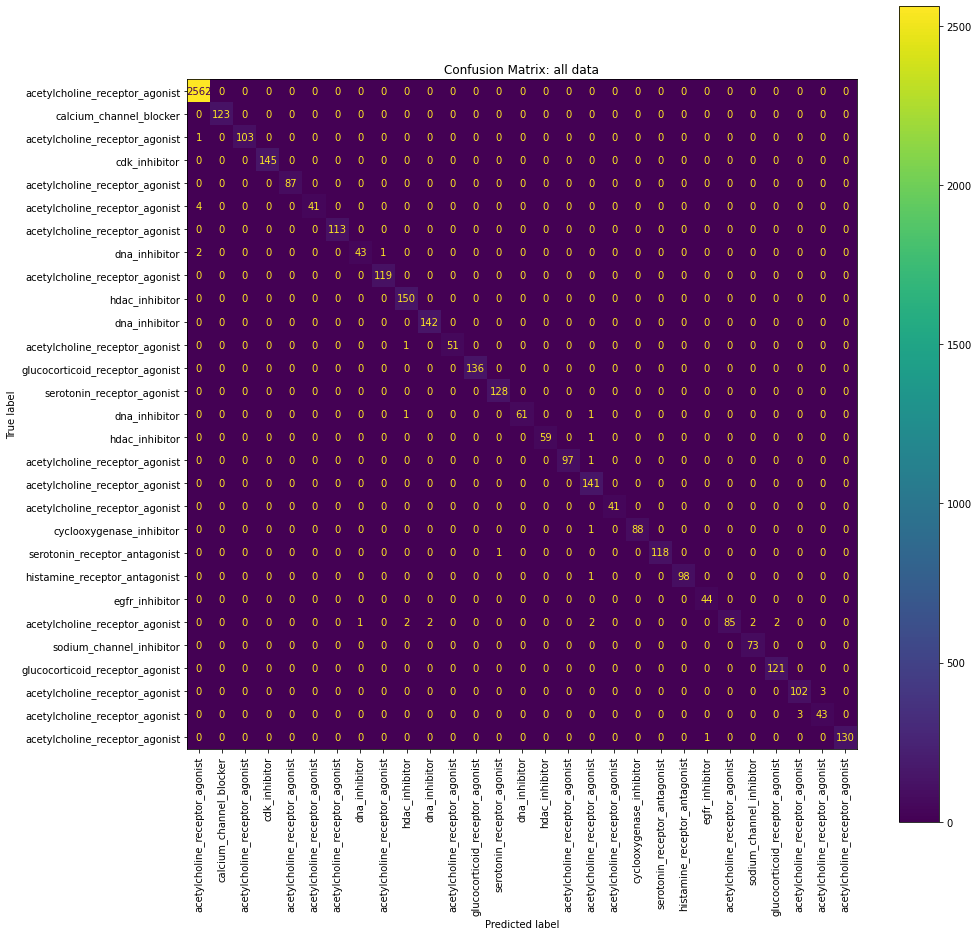

In [ ]:
# ConfusionMatrixDisplay(pd.Series(test_labels), y_pred)
fig, ax = plt.subplots(figsize=(15, 15))
# plot confusion matrix
disp1 = disp.plot(ax=ax, xticks_rotation='vertical')
ax.set_title('Confusion Matrix: all data')

Text(0.5, 1.0, 'Confusion Matrix: all data')

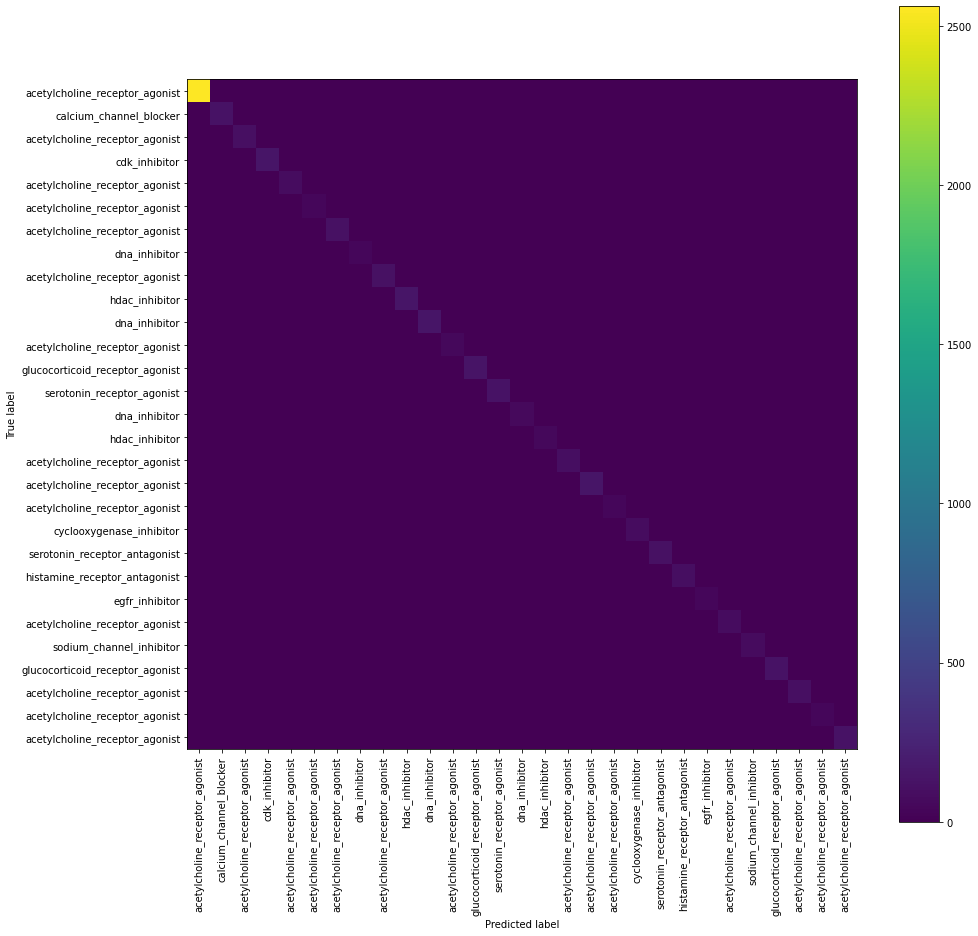

In [ ]:
# plot confusion matrix
ig, ax2 = plt.subplots(figsize=(15, 15))
disp2 = disp.plot(include_values=False, ax=ax2, xticks_rotation = 'vertical')
ax.set_title('Confusion Matrix: all data')

## Autogluon on g and c data only

Range of label counts: min = 157, max = 3126


Text(0, 0.5, '# Labels')

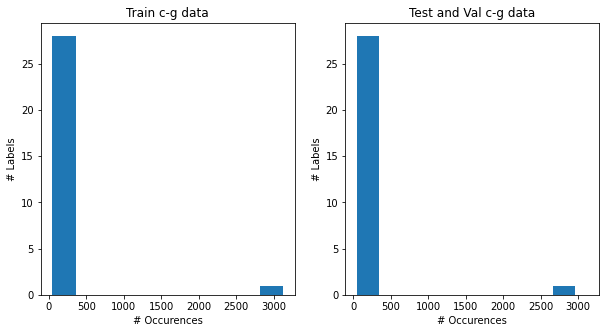

In [ ]:
temp_label_counts = np.unique(new_train_c_g['labels'].values, return_counts=True)[1]
print(f'Range of label counts: min = {temp_label_counts[-1]}, max = {temp_label_counts[0]}')

fig, (ax1_, ax2_) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
ax1_.hist(temp_label_counts, bins=10)
ax1_.set_title('Train c-g data')
ax1_.set_xlabel('# Occurences')
ax1_.set_ylabel('# Labels')

ax2_.hist(np.unique(train_c_g['labels'].values, return_counts=True)[1], bins=10)
ax2_.set_title('Test and Val c-g data')
ax2_.set_xlabel('# Occurences')
ax2_.set_ylabel('# Labels')

In [ ]:
save_path5 = 'g_c_autogluon_model'  # specifies folder to store trained models
# predictor = TabularPredictor(label='labels', path=DATA/save_path5).fit(new_train_c_g)

Beginning AutoGluon training ...
AutoGluon will save models to "/gdrive/My Drive/columbia_masters/classes/2021_f/genomics/genomics_project/g_c_autogluon_model/"
AutoGluon Version:  0.3.1
Train Data Rows:    6406
Train Data Columns: 872
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	First 10 (of 29) unique label values:  [0, 6, 8, 10, 18, 16, 24, 9, 25, 19]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 29
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    9441.09 MB
	Train Data (Original)  Memory Usage: 44.69 MB (0.5% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manual

In [ ]:
predictor = TabularPredictor.load(save_path5)
y_pred = predictor.predict(train_c_g.drop(columns='labels'))
print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true=train_c_g['labels'], y_pred=y_pred, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.5878223963434541
Evaluations on test data:
{
    "accuracy": 0.5878223963434541,
    "balanced_accuracy": 0.2436863175411777,
    "mcc": 0.38678525334788266
}


Predictions:  
 0        0
1        0
2        0
3        0
4       18
        ..
6121     0
6122     0
6123     0
6124     0
6125     8
Name: labels, Length: 6126, dtype: int64


In [ ]:
partial_autogluon_accuracies = predictor.leaderboard()
partial_autogluon_accuracies = partial_autogluon_accuracies.rename(columns={'score_val':'accuracy_val'})
partial_autogluon_accuracies

                  model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.597504       0.725556  3785.363931                0.003389           0.652876            2       True         13
1       NeuralNetFastAI   0.578783       0.333600    18.753044                0.333600          18.753044            1       True          3
2            LightGBMXT   0.578783       0.338430   838.631675                0.338430         838.631675            1       True          4
3               XGBoost   0.577223       0.191101  1637.723604                0.191101        1637.723604            1       True         11
4              LightGBM   0.575663       0.151707   956.229281                0.151707         956.229281            1       True          5
5              CatBoost   0.570983       0.029472  2731.427059                0.029472        2731.427059            1       True          8
6      Random

,model,accuracy_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.597504,0.725556,3785.363931,0.003389,0.652876,2,True,13
1,NeuralNetFastAI,0.578783,0.333600,18.753044,0.333600,18.753044,1,True,3
2,LightGBMXT,0.578783,0.338430,838.631675,0.338430,838.631675,1,True,4
3,XGBoost,0.577223,0.191101,1637.723604,0.191101,1637.723604,1,True,11
4,LightGBM,0.575663,0.151707,956.229281,0.151707,956.229281,1,True,5
5,CatBoost,0.570983,0.029472,2731.427059,0.029472,2731.427059,1,True,8
6,RandomForestGini,0.570983,0.207388,78.301671,0.207388,78.301671,1,True,6
7,LightGBMLarge,0.566303,0.320333,2428.539831,0.320333,2428.539831,1,True,12
8,RandomForestEntr,0.560062,0.207067,345.310725,0.207067,345.310725,1,True,7
9,ExtraTreesGini,0.550702,0.206985,10.433152,0.206985,10.433152,1,True,9


In [ ]:
name_labels1 = list(moa_label_names[train_c_g['labels'].astype(int)].values)
# get confusion matrix for predictions
cm5 = confusion_matrix(train_c_g['labels'], y_pred)
disp5 = ConfusionMatrixDisplay(confusion_matrix=cm5,
                              display_labels=name_labels1)

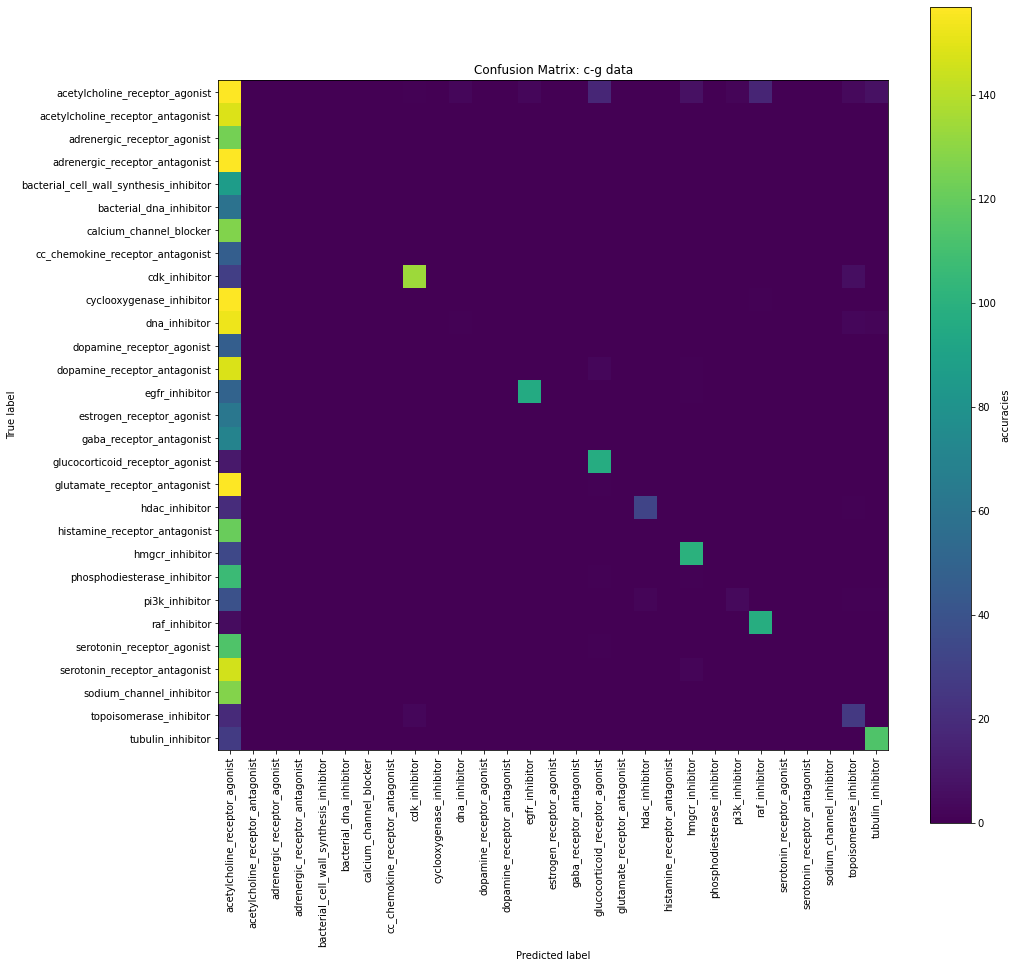

In [ ]:
accuracies = cm5#/cm.sum(1)
fig, ax = plt.subplots(figsize=(15, 15))
# plot confusion matrix
shw = ax.imshow(accuracies, cmap='viridis')
ax.set_title('Confusion Matrix: c-g data')

bar = plt.colorbar(shw)
  
# show plot with labels
plt.xlabel('Predicted label')
plt.ylabel('True label')
bar.set_label('accuracies')
plt.xticks(ticks=np.linspace(0, 28, 29), labels=moa_label_names, rotation='vertical')
plt.yticks(ticks=np.linspace(0, 28, 29), labels=moa_label_names)

shw.set_clim(0, temp_label_counts[-1])
plt.show()

Text(0.5, 1.0, 'Confusion Matrix: c-g data')

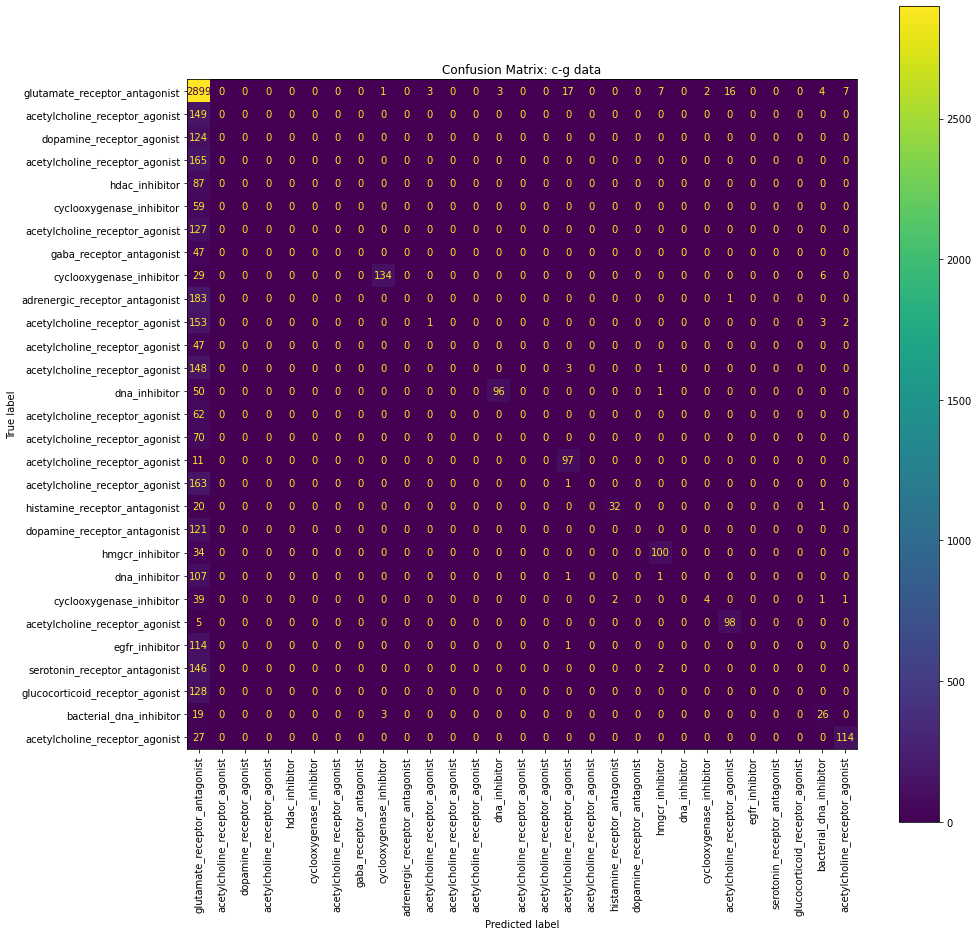

In [ ]:
# ConfusionMatrixDisplay(pd.Series(test_labels), y_pred)
ig, ax = plt.subplots(figsize=(15, 15))
# plot confusion matrix
disp_ = disp5.plot(ax=ax, xticks_rotation = 'vertical')
ax.set_title('Confusion Matrix: c-g data')

### Autogluon with t-sne

Range of label counts: min = 157, max = 3126


Text(0, 0.5, '# Labels')

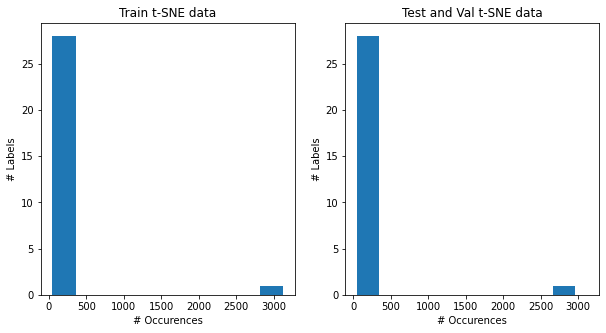

In [ ]:
temp_label_counts = np.unique(new_train_tsne['labels'].values, return_counts=True)[1]
print(f'Range of label counts: min = {temp_label_counts[-1]}, max = {temp_label_counts[0]}')
fig, (ax1_, ax2_) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
ax1_.hist(temp_label_counts, bins=10)
ax1_.set_title('Train t-SNE data')
ax1_.set_xlabel('# Occurences')
ax1_.set_ylabel('# Labels')

ax2_.hist(np.unique(new_test_tsne['labels'].values, return_counts=True)[1], bins=10)
ax2_.set_title('Test and Val t-SNE data')
ax2_.set_xlabel('# Occurences')
ax2_.set_ylabel('# Labels')

In [ ]:
save_path2 = 'tsne_autogluon_model'  # specifies folder to store trained models
# predictor2 = TabularPredictor(label='labels', path=DATA/save_path2).fit(new_train_tsne)

Beginning AutoGluon training ...
AutoGluon will save models to "/gdrive/My Drive/columbia_masters/classes/2021_f/genomics/genomics_project/tsne_autogluon_model/"
AutoGluon Version:  0.3.1
Train Data Rows:    6406
Train Data Columns: 2
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	First 10 (of 29) unique label values:  [0, 6, 8, 10, 18, 16, 24, 9, 25, 19]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 29
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    7614.36 MB
	Train Data (Original)  Memory Usage: 0.05 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually

In [ ]:
save_path2 = 'tsne_autogluon_model'

In [ ]:
predictor2 = TabularPredictor.load(save_path2)
y_pred2 = predictor2.predict(new_test_tsne.drop(columns=['labels']))
print("Predictions:  \n", y_pred2)
perf = predictor2.evaluate_predictions(y_true=new_test_tsne['labels'], y_pred=y_pred2, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.4524975514201763
Evaluations on test data:
{
    "accuracy": 0.4524975514201763,
    "balanced_accuracy": 0.03256341509361767,
    "mcc": -0.00573221669241355
}


Predictions:  
 0        0
1        0
2        0
3       28
4       16
        ..
6121     0
6122     0
6123     0
6124     0
6125     0
Name: labels, Length: 6126, dtype: int64


In [ ]:
tsne_autogluon_accuracies = predictor2.leaderboard()
tsne_autogluon_accuracies = tsne_autogluon_accuracies.rename(columns={'score_val':'accuracy_val'})
tsne_autogluon_accuracies

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.575663       1.048955  73.233252                0.000981           0.921580            2       True         13
1              LightGBM   0.564743       0.025659   5.537528                0.025659           5.537528            1       True          5
2         LightGBMLarge   0.563183       0.025512  14.022789                0.025512          14.022789            1       True         12
3               XGBoost   0.563183       0.029500   6.558862                0.029500           6.558862            1       True         11
4            LightGBMXT   0.563183       0.240415  33.520364                0.240415          33.520364            1       True          4
5       NeuralNetFastAI   0.560062       0.031279  18.919130                0.031279          18.919130            1       True          3
6              CatBoost   0

,model,accuracy_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.575663,1.048955,73.233252,0.000981,0.921580,2,True,13
1,LightGBM,0.564743,0.025659,5.537528,0.025659,5.537528,1,True,5
2,LightGBMLarge,0.563183,0.025512,14.022789,0.025512,14.022789,1,True,12
3,XGBoost,0.563183,0.029500,6.558862,0.029500,6.558862,1,True,11
4,LightGBMXT,0.563183,0.240415,33.520364,0.240415,33.520364,1,True,4
5,NeuralNetFastAI,0.560062,0.031279,18.919130,0.031279,18.919130,1,True,3
6,CatBoost,0.556942,0.009841,5.787583,0.009841,5.787583,1,True,8
7,KNeighborsUnif,0.550702,0.109074,0.012878,0.109074,0.012878,1,True,1
8,ExtraTreesGini,0.533541,0.202991,1.658499,0.202991,1.658499,1,True,9
9,ExtraTreesEntr,0.533541,0.204728,2.439578,0.204728,2.439578,1,True,10


In [ ]:
name_labels1 = list(moa_label_names[new_test_tsne['labels'].astype(int)].values)

In [ ]:
# get confusion matrix for predictions
cm2 = confusion_matrix(new_test_tsne['labels'], y_pred2)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm2,
                              display_labels=name_labels1)

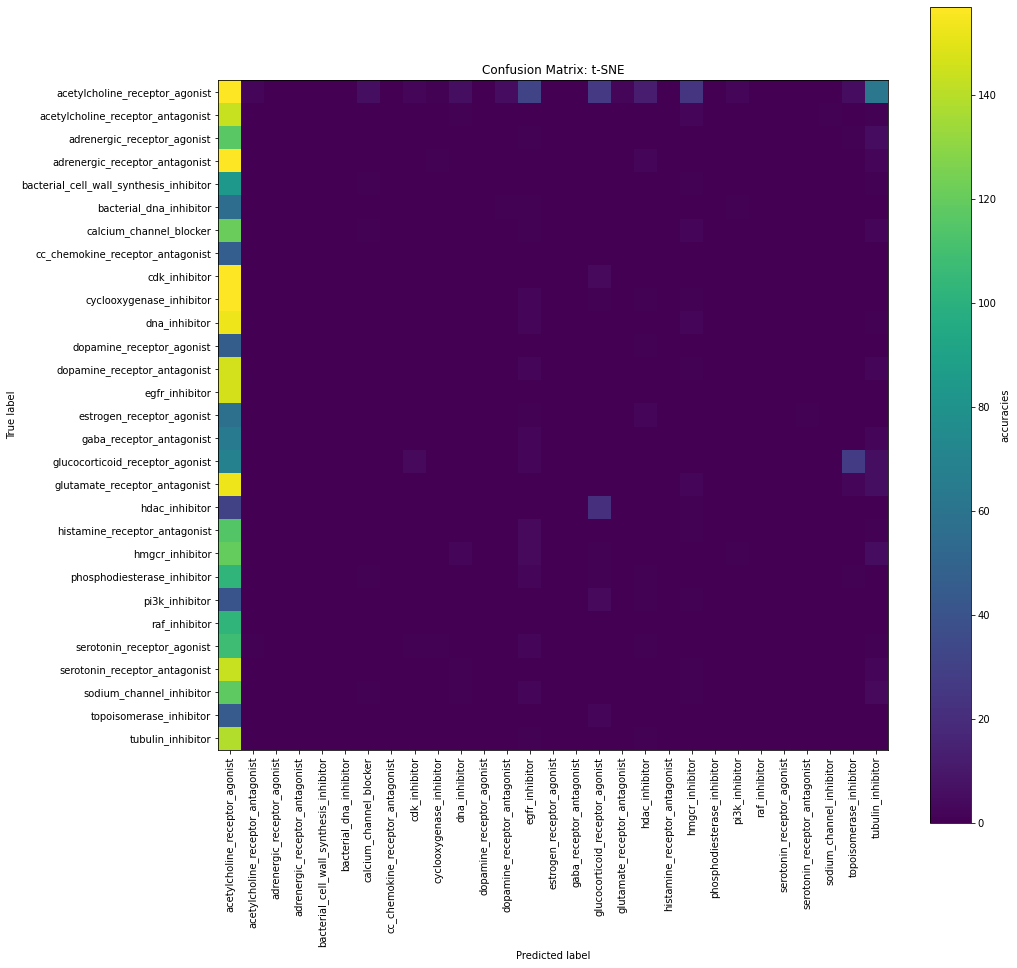

In [ ]:
accuracies = cm2#/cm.sum(1)
fig, ax = plt.subplots(figsize=(15, 15))
# plot confusion matrix
shw = ax.imshow(accuracies, cmap='viridis')
ax.set_title('Confusion Matrix: t-SNE')

bar = plt.colorbar(shw)
  
# show plot with labels
plt.xlabel('Predicted label')
plt.ylabel('True label')
bar.set_label('accuracies')
plt.xticks(ticks=np.linspace(0, 28, 29), labels=moa_label_names, rotation='vertical')
plt.yticks(ticks=np.linspace(0, 28, 29), labels=moa_label_names)

shw.set_clim(0, temp_label_counts[-1])
plt.show()

Text(0.5, 1.0, 'Confusion Matrix: t-SNE data')

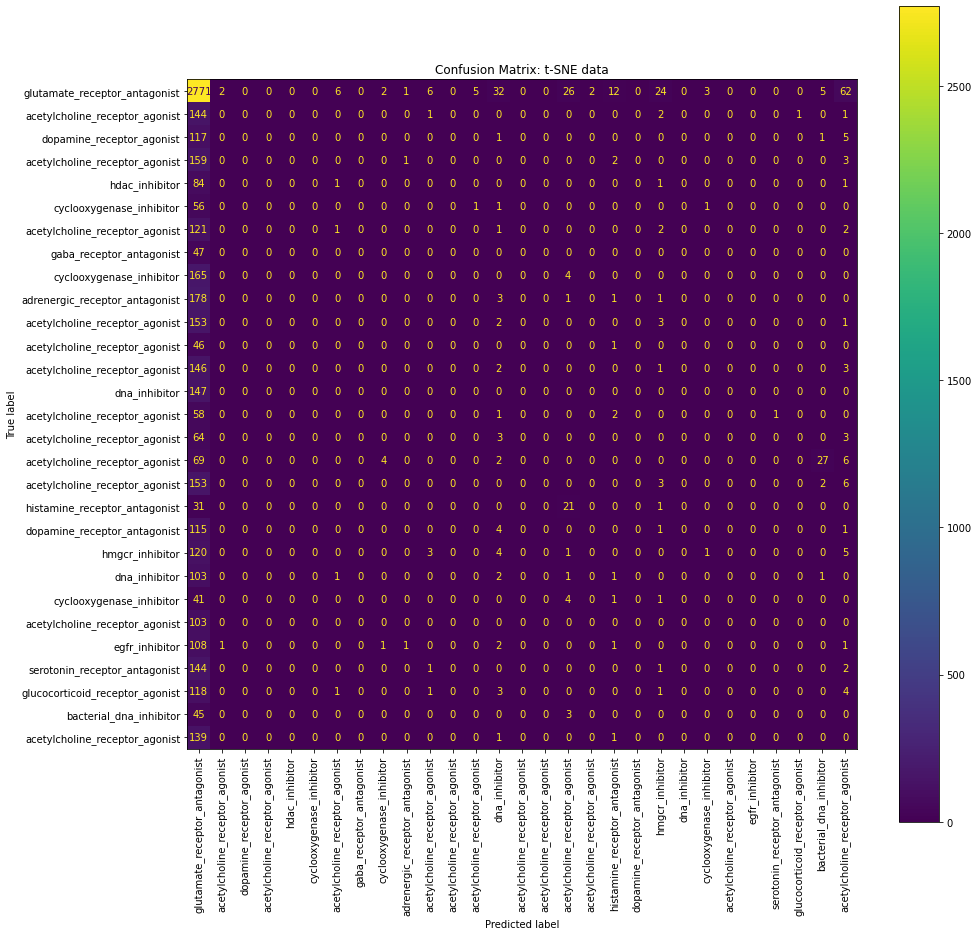

In [ ]:
# ConfusionMatrixDisplay(pd.Series(test_labels), y_pred)
ig, ax = plt.subplots(figsize=(15, 15))
# plot confusion matrix
disp1 = disp1.plot(ax=ax, xticks_rotation = 'vertical')
ax.set_title('Confusion Matrix: t-SNE data')

Text(0.5, 1.0, 'Confusion Matrix: t-SNE data')

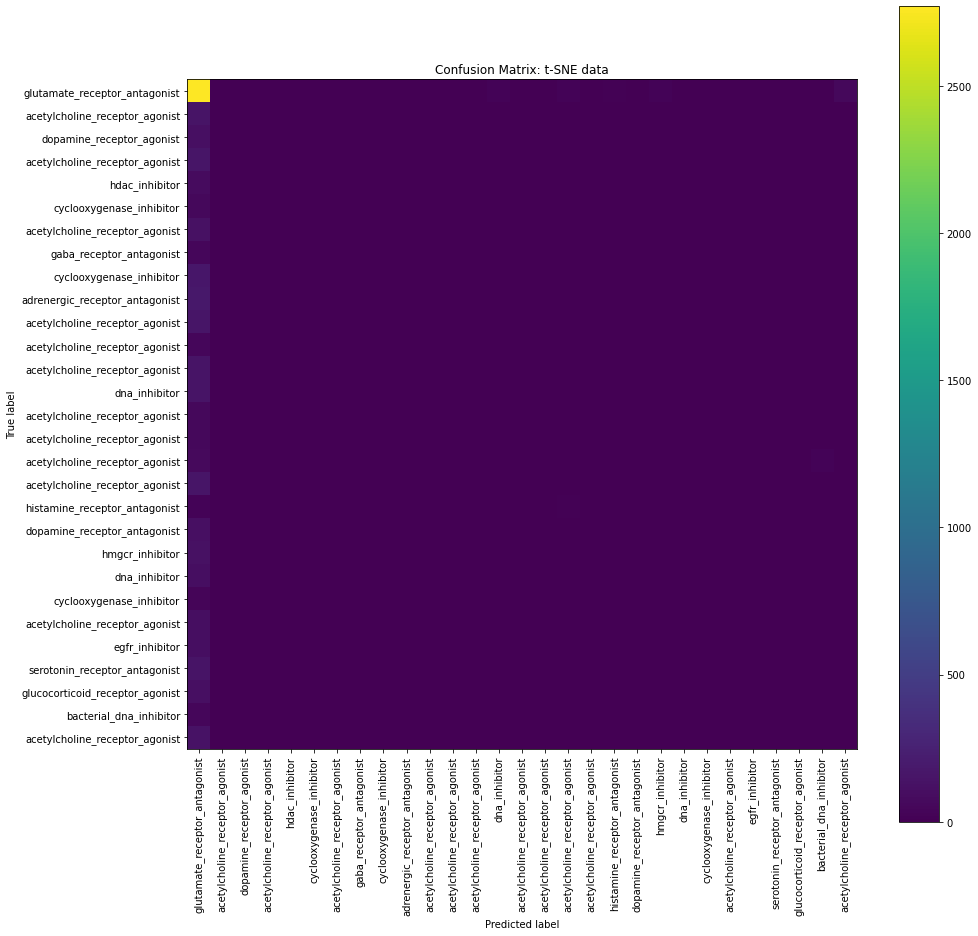

In [ ]:
# plot confusion matrix
ig, ax2 = plt.subplots(figsize=(15, 15))
disp2 = disp1.plot(include_values=False, ax=ax2, xticks_rotation = 'vertical')
ax2.set_title('Confusion Matrix: t-SNE data')

### t-SNE balanced-ish data

In [95]:
bal_train_tsne = new_train_tsne.reset_index(drop=True)

# see which class we need to compensate for
np.unique(bal_train_tsne['labels'].values, return_counts=True)
# we can see it's class zero

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 array([3126,  146,  122,  170,   99,   56,  136,   55,  147,  190,  171,
          55,  158,  152,   72,   77,  116,  173,   47,  114,  149,  125,
          56,  113,   90,  146,  127,   61,  157]))

In [96]:
# so, we'll drop occurences of that class, keeping only 200 occurences (randomly selected drops).
# 200 seems like a comparable number to the other classes' occurences.
class0_idx = (np.where(bal_train_tsne['labels']==0)[0])
drop_idx = random.sample(range(len(class0_idx)), 3126-200)

In [97]:
bal_train_tsne = bal_train_tsne.drop(labels=drop_idx, axis=0).reset_index(drop=True)

Range of label counts: min = 91, max = 1715


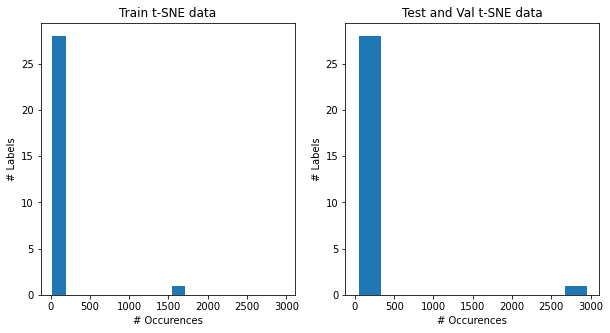

In [98]:
temp_label_counts = np.unique(bal_train_tsne['labels'].values, return_counts=True)[1]
print(f'Range of label counts: min = {temp_label_counts[-1]}, max = {temp_label_counts[0]}')
fig, (ax1_, ax2_) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
ax1_.hist(temp_label_counts, bins=10)
ax1_.set_title('Train t-SNE data')
ax1_.set_xlabel('# Occurences')
ax1_.set_ylabel('# Labels')

ax2_.hist(np.unique(new_test_tsne['labels'].values, return_counts=True)[1], bins=10)
ax2_.set_title('Test and Val t-SNE data')
ax2_.set_xlabel('# Occurences')
ax2_.set_ylabel('# Labels')

save_path2 = 'tsne_autogluon_model'  # specifies folder to store trained models
# predictor2 = TabularPredictor(label='labels', path=DATA/save_path2).fit(new_train_tsne)

In [99]:
save_path6 = 'bal_tsne_autogluon_model'  # specifies folder to store trained models
predictor6 = TabularPredictor(label='labels', path=DATA/save_path6).fit(bal_train_tsne)

Beginning AutoGluon training ...
AutoGluon will save models to "/gdrive/My Drive/columbia_masters/classes/2021_f/genomics/genomics_project/bal_tsne_autogluon_model/"
AutoGluon Version:  0.3.1
Train Data Rows:    3480
Train Data Columns: 2
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	First 10 (of 29) unique label values:  [6, 0, 18, 3, 28, 8, 24, 25, 4, 1]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 29
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    8615.58 MB
	Train Data (Original)  Memory Usage: 0.03 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manual

In [103]:
predictor6 = TabularPredictor.load(save_path6)
y_pred6 = predictor6.predict(new_test_tsne.drop(columns=['labels']))
print("Predictions:  \n", y_pred6)
perf = predictor6.evaluate_predictions(y_true=new_test_tsne['labels'], y_pred=y_pred6, auxiliary_metrics=True)

tsne_autogluon_accuracies = predictor6.leaderboard()
tsne_autogluon_accuracies = tsne_autogluon_accuracies.rename(columns={'score_val':'accuracy_val'})
tsne_autogluon_accuracies

name_labels1 = list(moa_label_names[new_test_tsne['labels'].astype(int)].values)

Evaluation: accuracy on test data: 0.5714985308521058
Evaluations on test data:
{
    "accuracy": 0.5714985308521058,
    "balanced_accuracy": 0.21558109973023173,
    "mcc": 0.3524428567704084
}


Predictions:  
 0        0
1        0
2        0
3        0
4       18
        ..
6121     0
6122     0
6123     0
6124     0
6125     8
Name: labels, Length: 6126, dtype: int64
                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2      0.578       0.973965  23.435750                0.004835           2.021898            2       True         13
1            LightGBMXT      0.576       0.241778   5.680235                0.241778           5.680235            1       True          4
2              CatBoost      0.572       0.005807   5.926473                0.005807           5.926473            1       True          8
3               XGBoost      0.572       0.016887   3.856479                0.016887           3.856479            1       True         11
4       NeuralNetFastAI      0.566       0.023057   5.825500                0.023057           5.825500            1       True

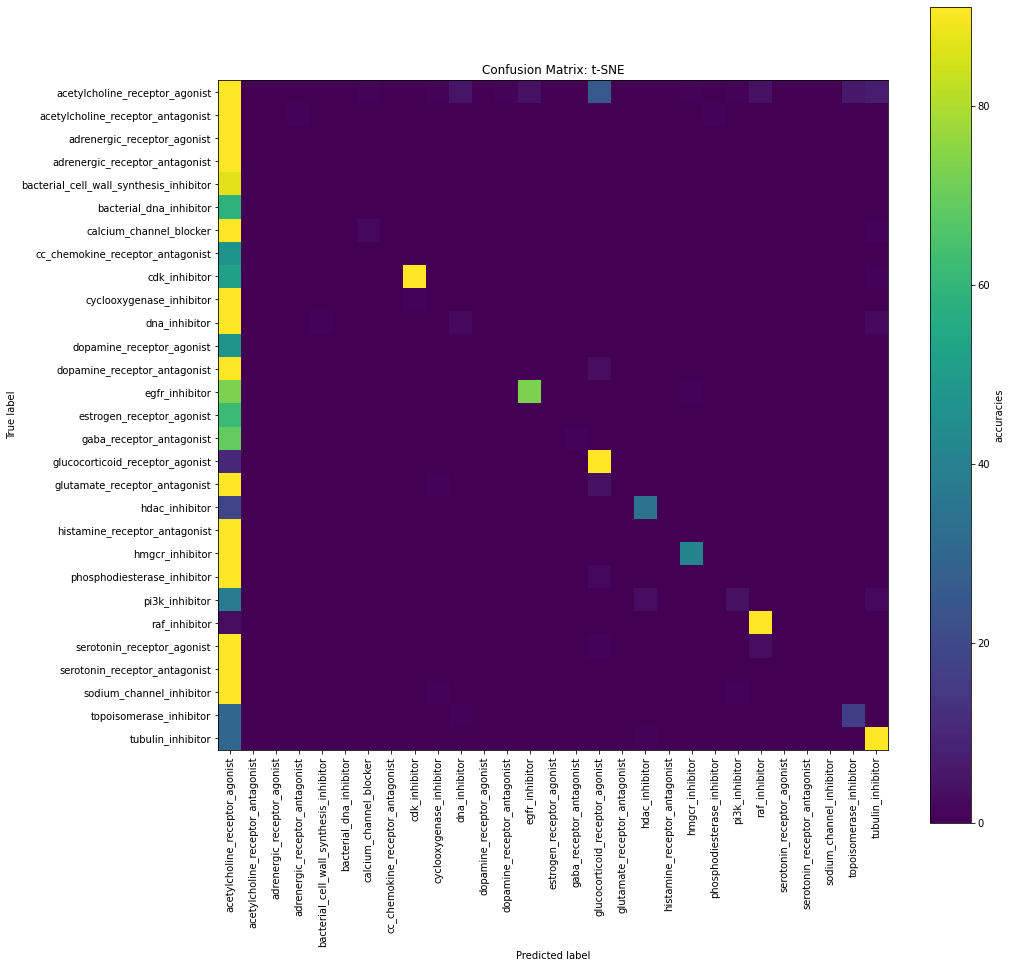

In [104]:
# get confusion matrix for predictions
cm6 = confusion_matrix(new_test_tsne['labels'], y_pred6)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm6,
                              display_labels=name_labels1)

accuracies = cm6#/cm.sum(1)
fig, ax = plt.subplots(figsize=(15, 15))
# plot confusion matrix
shw = ax.imshow(accuracies, cmap='viridis')
ax.set_title('Confusion Matrix: t-SNE')

bar = plt.colorbar(shw)
  
# show plot with labels
plt.xlabel('Predicted label')
plt.ylabel('True label')
bar.set_label('accuracies')
plt.xticks(ticks=np.linspace(0, 28, 29), labels=moa_label_names, rotation='vertical')
plt.yticks(ticks=np.linspace(0, 28, 29), labels=moa_label_names)

shw.set_clim(0, temp_label_counts[-1])
plt.show()

### Autogluon with PHATE

Range of label counts: min = 157, max = 3126


Text(0, 0.5, '# Labels')

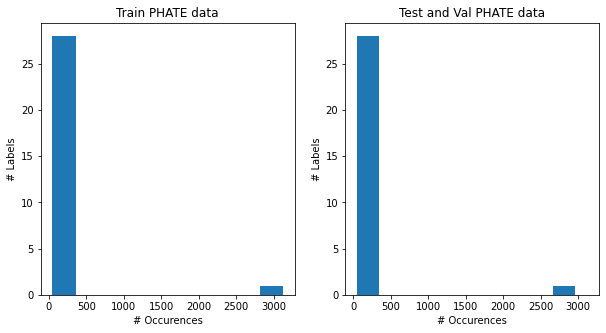

In [ ]:
temp_label_counts = np.unique(new_train_phate['labels'].values, return_counts=True)[1]
print(f'Range of label counts: min = {temp_label_counts[-1]}, max = {temp_label_counts[0]}')
fig, (ax1_, ax2_) = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
ax1_.hist(temp_label_counts, bins=10)
ax1_.set_title('Train PHATE data')
ax1_.set_xlabel('# Occurences')
ax1_.set_ylabel('# Labels')

ax2_.hist(np.unique(new_test_phate['labels'].values, return_counts=True)[1], bins=10)
ax2_.set_title('Test and Val PHATE data')
ax2_.set_xlabel('# Occurences')
ax2_.set_ylabel('# Labels')

In [ ]:
save_path3 = 'phate_autogluon_model'  # specifies folder to store trained models
# predictor3 = TabularPredictor(label='labels', path=DATA/save_path3).fit(new_train_phate)

Beginning AutoGluon training ...
AutoGluon will save models to "/gdrive/My Drive/columbia_masters/classes/2021_f/genomics/genomics_project/phate_autogluon_model/"
AutoGluon Version:  0.3.1
Train Data Rows:    6406
Train Data Columns: 2
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	First 10 (of 29) unique label values:  [0, 6, 8, 10, 18, 16, 24, 9, 25, 19]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 29
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    7322.92 MB
	Train Data (Original)  Memory Usage: 0.1 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually

In [ ]:
predictor3 = TabularPredictor.load(save_path3)
y_pred3 = predictor3.predict(new_test_phate.drop(columns=['labels']))
print("Predictions:  \n", y_pred3)
perf = predictor3.evaluate_predictions(y_true=new_test_phate['labels'], y_pred=y_pred3, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.5360757427358799
Evaluations on test data:
{
    "accuracy": 0.5360757427358799,
    "balanced_accuracy": 0.1479560143843447,
    "mcc": 0.2639634072874404
}


Predictions:  
 0       0
1       0
2       0
3       0
4       0
       ..
6121    0
6122    0
6123    0
6124    0
6125    8
Name: labels, Length: 6126, dtype: int64


In [ ]:
phate_autogluon_accuracies = predictor3.leaderboard()
phate_autogluon_accuracies = phate_autogluon_accuracies.rename(columns={'score_val':'accuracy_val'})
phate_autogluon_accuracies

                  model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2   0.564743       0.243996  18.958103                0.000658           0.609832            2       True         13
1               XGBoost   0.563183       0.020584   5.411705                0.020584           5.411705            1       True         11
2              CatBoost   0.556942       0.023212  19.432676                0.023212          19.432676            1       True          8
3              LightGBM   0.555382       0.013304   7.212991                0.013304           7.212991            1       True          5
4       NeuralNetFastAI   0.552262       0.019787   8.972454                0.019787           8.972454            1       True          3
5         LightGBMLarge   0.549142       0.022480  14.428030                0.022480          14.428030            1       True         12
6            LightGBMXT   0

,model,accuracy_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.564743,0.243996,18.958103,0.000658,0.609832,2,True,13
1,XGBoost,0.563183,0.020584,5.411705,0.020584,5.411705,1,True,11
2,CatBoost,0.556942,0.023212,19.432676,0.023212,19.432676,1,True,8
3,LightGBM,0.555382,0.013304,7.212991,0.013304,7.212991,1,True,5
4,NeuralNetFastAI,0.552262,0.019787,8.972454,0.019787,8.972454,1,True,3
5,LightGBMLarge,0.549142,0.022480,14.428030,0.022480,14.428030,1,True,12
6,LightGBMXT,0.549142,0.381437,46.990908,0.381437,46.990908,1,True,4
7,KNeighborsUnif,0.508580,0.107666,0.019777,0.107666,0.019777,1,True,1
8,ExtraTreesGini,0.503900,0.202725,1.908056,0.202725,1.908056,1,True,9
9,ExtraTreesEntr,0.503900,0.202943,1.961677,0.202943,1.961677,1,True,10


In [ ]:
name_labels1 = list(moa_label_names[new_test_phate['labels'].astype(int)].values)

In [ ]:
# get confusion matrix for predictions
cm3 = confusion_matrix(new_test_phate['labels'], y_pred3)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3,
                              display_labels=name_labels1)

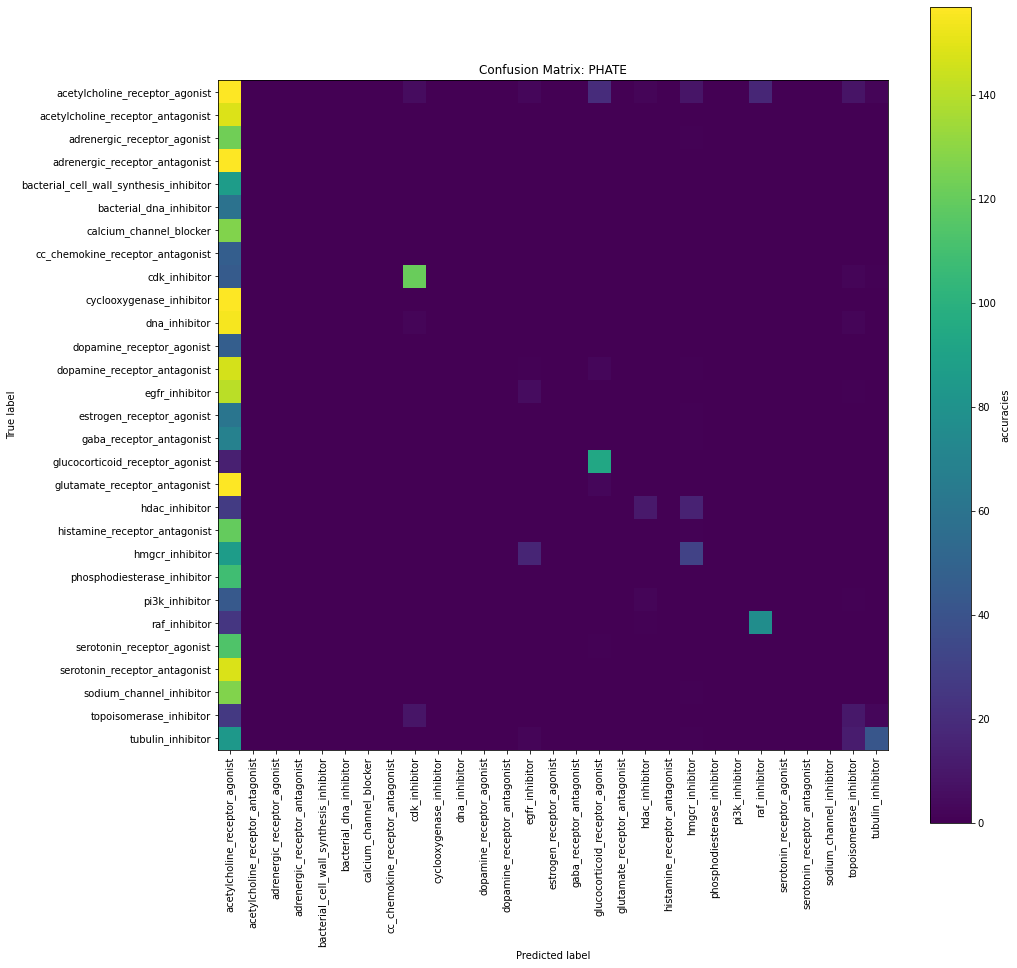

In [ ]:
accuracies = cm3#/cm.sum(1)
fig, ax = plt.subplots(figsize=(15, 15))
# plot confusion matrix
shw = ax.imshow(accuracies, cmap='viridis')
ax.set_title('Confusion Matrix: PHATE')

bar = plt.colorbar(shw)
  
# show plot with labels
plt.xlabel('Predicted label')
plt.ylabel('True label')
bar.set_label('accuracies')
plt.xticks(ticks=np.linspace(0, 28, 29), labels=moa_label_names, rotation='vertical')
plt.yticks(ticks=np.linspace(0, 28, 29), labels=moa_label_names)

shw.set_clim(0, temp_label_counts[-1])
plt.show()

Text(0.5, 1.0, 'Confusion Matrix: PHATE data')

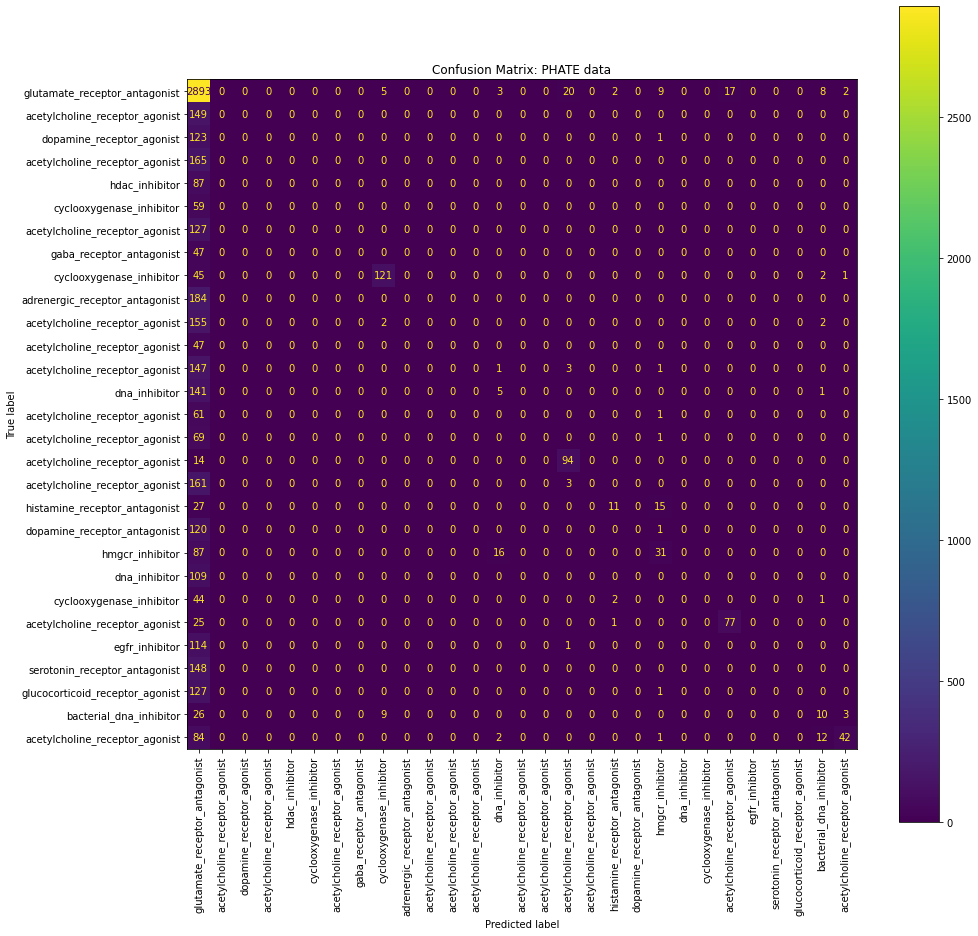

In [ ]:
# ConfusionMatrixDisplay(pd.Series(test_labels), y_pred)
ig, ax = plt.subplots(figsize=(15, 15))
# plot confusion matrix
disp1 = disp3.plot(ax=ax, xticks_rotation = 'vertical')
ax.set_title('Confusion Matrix: PHATE data')

Text(0.5, 1.0, 'Confusion Matrix: PHATE data')

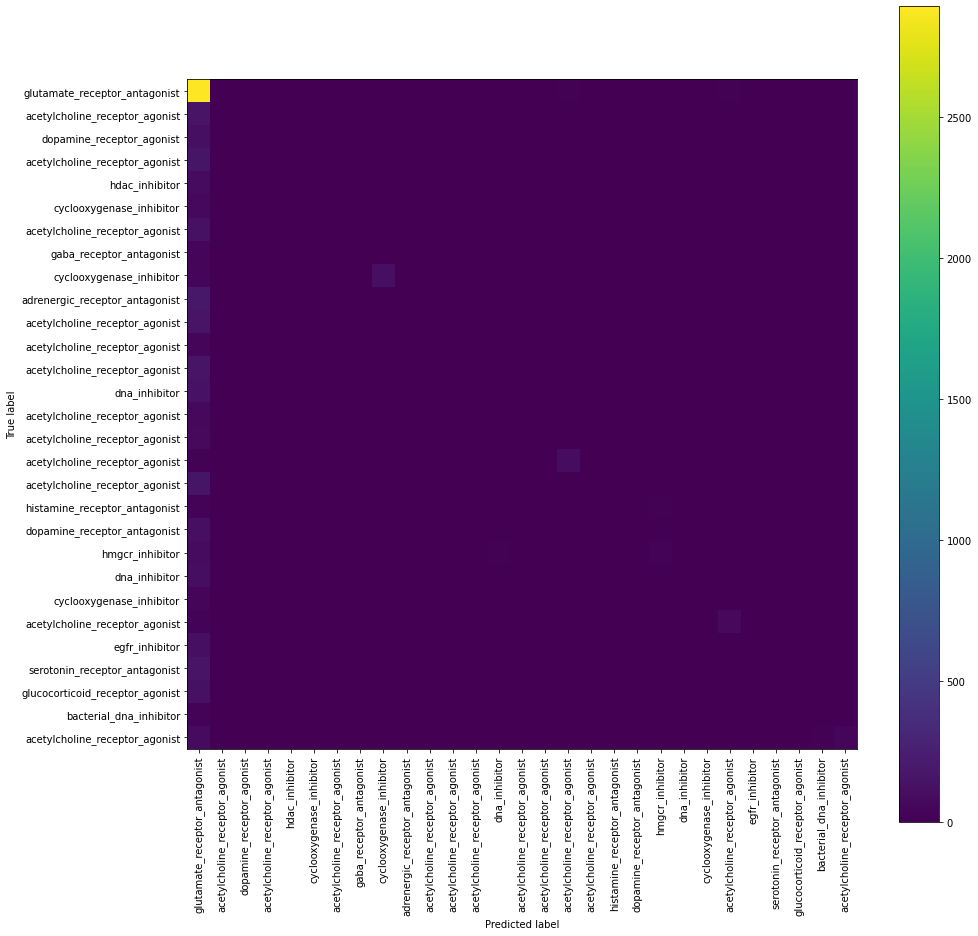

In [ ]:
# plot confusion matrix
ig, ax2 = plt.subplots(figsize=(15, 15))
disp2 = disp3.plot(include_values=False, ax=ax2, xticks_rotation = 'vertical')
ax.set_title('Confusion Matrix: PHATE data')

### NN all data

In [118]:
inputs=Input(shape=(train_features.iloc[0].shape[0]-1, 1), name='inputs')

dense1 = Dense(32, activation='relu')(inputs)
con1 = Conv1D(32, (6), activation='relu', name='conv1d_1')(dense1)
birnn1 = Bidirectional(SimpleRNN(64))(con1)
drop1 = Dropout(0.3)(birnn1)
bn1 = BatchNormalization()(drop1)
dense2 = Dense(32, activation='relu')(bn1)
drop2 = Dropout(0.3)(dense2)
bn2 = BatchNormalization()(drop2)
main_output = Dense(1, activation='softmax')(bn2)

model1 = Model(inputs= inputs, outputs=main_output, name='BiRNN_Model')
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model1.summary()

Model: "BiRNN_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 876, 1)]          0         
                                                                 
 dense_9 (Dense)             (None, 876, 32)           64        
                                                                 
 conv1d_1 (Conv1D)           (None, 871, 32)           6176      
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              12416     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 128)              512       
 hNormalization)                                       

In [119]:
# apply early stopping to prevent overfitting, or prevent resource waste if the
# model is really bad
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
# here we need to use the np features because tensorflow accepts them better
# so, we'll use nptrain_features, nptest_features, npval_features
exp_train = np.expand_dims(nptrain_features, axis=2)
exp_val = np.expand_dims(npval_features, axis=2)
exp_test = np.expand_dims(nptest_features, axis=2)

# test_data = test_features
# test_data['labels'] = test_labels

history1 = model1.fit(convert_to_tensor(exp_train, dtype=tf.float64), convert_to_tensor(train_labels, dtype=tf.float64),
                      epochs=10, batch_size=64,
                      validation_data=(convert_to_tensor(exp_val, dtype=tf.float64), convert_to_tensor(val_labels, dtype=tf.float64)),
                      callbacks=[es])


Epoch 1/10
96/96 [==============================] - 82s 798ms/step - loss: nan - accuracy: 0.4830 - val_loss: nan - val_accuracy: 0.5000
Epoch 2/10
96/96 [==============================] - 68s 709ms/step - loss: nan - accuracy: 0.4830 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/10
96/96 [==============================] - 66s 687ms/step - loss: nan - accuracy: 0.4830 - val_loss: nan - val_accuracy: 0.5000
Epoch 00003: early stopping


Since the neural network itself did a lot worse than the autogluon, we decided to not use it.